# Homework2

## Introduction

- This notebook will apply the cleaned dataset from homework 1 and use it to create 3 different models to predict whether an applicant for credit will repay their credit within 2 years.
    - The value 0 indicates that an animal will have a positive outcome (adopted/returned to owner).
    - The value 1 indicates that an animal will have a negative outcome (death).
- Each model will be a supervised learning model and the output will be a binary classification. 
- For each applicant a number of features will be given (independent variables) and the target, risk performance (dependent variable), will be predicted.

This homework will be broken down into 5 main parts:
1. Review the dataset from homework one and decide on which features to use to build our model
2. Create a Linear Regression model and analyse
3. Create a Logistical Regression model and analyse
4. Create a Random Forest model and analyse
5. Try to optimize each model

We will begin by importing the packages needed for this assignment. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1) Data Understanding and Prep

The original dataset was cleaned in homework 1 and will now be imported as a starting point for this homework. There are some points to note before proceeding: 

- The cleaned dataset will be a starting point however, some additional cleaning steps will be performed before proceeding with homework2. 
- The data quality report for the cleaned dataset has been provided as a reference. 
- A summary of the data quality plan is seen below. 
- Based on the findings in homework1, four additional features were added. These are: 
    - 'SexKnown' which indicates whether the sex of an animal is known or not. 
    - 'CatOrDog' which indicates whether an animal is either a cat or a dog or not. 
    - 'AgeIntake_bins which grouped the ages of animals upon intake into four equal frequency bins.
    - 'SickOrInjured' which indicates whether an animal was sick/injured or not. 

## Insert data quality plan table here!

We will begin by importing the cleaned dataset from homework 1. 

In [2]:
# read in the cleaned csv
df = pd.read_csv("19205514_cleaned_new_features_added.csv")

## Data integrity checks

Before going any further we will now perform some data integrity checks on the dataset which we have just imported. 

We will now begin by taking a look at the shape of the dataset and first five lines. 

In [3]:
#look at the shape of the dataset
df.shape

(1000, 23)

In [4]:
df.head(5)

,AnimalID,Name_Provided,DateTime_Intake,FoundLocation,IntakeType,IntakeCondition,AnimalType_Intake,SexuponIntake,AgeuponIntake,Breed_Intake,...,SexuponOutcome,AgeuponOutcome,binary_outcome,ColorOriginal,BreedOriginal,percent,SexKnown,CatOrDog,AgeIntake_bins,SickOrInjured
0,A687076,Yes,2014-08-30 17:55:00,Austin (TX),Stray,Normal,Cat,Intact Female,76,Mixed Breed,...,Spayed Female,82,0,Torbie,Domestic Shorthair Mix,0.109769,1,1,"(55.8, 92.0]",0
1,A685139,No,2014-08-03 11:23:00,Austin (TX),Stray,Other,Dog,Intact Female,92,Mixed Breed,...,Spayed Female,96,0,White/Black,Cavalier Span Mix,0.109769,1,1,"(55.8, 92.0]",0
2,A741039,Yes,2016-12-27 11:18:00,Austin (TX),Stray,Normal,Dog,Intact Male,366,Pure Breed,...,Intact Male,371,0,Black/White,Jack Russell Terrier,0.109769,1,1,"(365.0, 427.6]",0
3,A759166,Yes,2017-09-28 11:03:00,Austin (TX),Stray,Normal,Cat,Intact Male,62,Pure Breed,...,Neutered Male,99,0,Black,Domestic Shorthair,0.109769,1,1,"(55.8, 92.0]",0
4,A696479,Yes,2015-02-05 11:51:00,Travis (TX),Stray,Normal,Cat,Intact Male,365,Mixed Breed,...,Neutered Male,375,0,Black,Domestic Medium Hair Mix,0.109769,1,1,"(212.0, 365.0]",0


We can see that the feature 'percent' is still in the dataset. This was generating while implementing bar plots in homework1 and should not be part of the dataset. We will now drop this feature. 

In [5]:
#drop the feature 'percent'
df = df.drop("percent", 1)

Next, in order to conduct some integrity tests, we will look at the datatypes of our features after importing the csv. 

In [6]:
df.dtypes

AnimalID             object
Name_Provided        object
DateTime_Intake      object
FoundLocation        object
IntakeType           object
IntakeCondition      object
AnimalType_Intake    object
SexuponIntake        object
AgeuponIntake         int64
Breed_Intake         object
Color_Intake         object
DateTime_Outcome     object
DateofBirth          object
SexuponOutcome       object
AgeuponOutcome        int64
binary_outcome        int64
ColorOriginal        object
BreedOriginal        object
SexKnown              int64
CatOrDog              int64
AgeIntake_bins       object
SickOrInjured         int64
dtype: object

We can see that the datatpyes of some features have reverted back to type "object". We will now convert these features back to their appropriate types. 

Although the target feature *binary_outcome* is a categorical feature, will need to be an int when creating scatter plots in the next section, so we can leave it as it is at this stage. 

In [7]:
#convert all objects to categories
object_columns = df.select_dtypes(['object']).columns
for column in object_columns:
    df[column] = df[column].astype('category')

#convert animal ID to an object type
df['AnimalID'] = df['AnimalID'].astype('object')  

#convert the new features 'SexKnown','CatOrDog' and 'SickOrInjured' back to category type as this 
#is how they were implemented in homework1.
new_features = ['SexKnown','CatOrDog', 'SickOrInjured']
for column in new_features:
    df[column] = df[column].astype('category')
    
#convert all date features to datetime types
date_columns = ['DateTime_Intake', 'DateTime_Outcome', 'DateofBirth']
for column in date_columns: 
    df[column] = df[column].astype('datetime64[ns]')
    
#convert binary outcome to category type
# df['binary_outcome'] = df['binary_outcome'].astype('category') 

In [8]:
df.dtypes

AnimalID                     object
Name_Provided              category
DateTime_Intake      datetime64[ns]
FoundLocation              category
IntakeType                 category
IntakeCondition            category
AnimalType_Intake          category
SexuponIntake              category
AgeuponIntake                 int64
Breed_Intake               category
Color_Intake               category
DateTime_Outcome     datetime64[ns]
DateofBirth          datetime64[ns]
SexuponOutcome             category
AgeuponOutcome                int64
binary_outcome                int64
ColorOriginal              category
BreedOriginal              category
SexKnown                   category
CatOrDog                   category
AgeIntake_bins             category
SickOrInjured              category
dtype: object

We are now ready to perform some data integrity tests. 

Test 1: Check if the 'DateTime_Outcome' is an earlier date than the 'DateTime_Intake' for any of the animals. This would imply that the animal stayed a negative length of time in the shelter which is impossible.

In [9]:
#create a dataframe containing the instances where date of outcome is less than date of intake
test_1 = df[['DateTime_Outcome','DateTime_Intake']][df['DateTime_Outcome'] < df['DateTime_Intake']]
#print out the number of instances failing the test
print("Number of rows failing the test: ", test_1.shape[0])
#view the instances
test_1.head()

Number of rows failing the test:  0


,DateTime_Outcome,DateTime_Intake


 - **Test 2:** Check if the *'DateTime_Intake'* for any animal is before their *'DateofBirth'*. This would imply that the animal entered the shelter before they were born which is impossible.

In [10]:
#create a dataframe containing the instances where date of intake is less than date of birth
test_2 = df[['DateTime_Intake','DateofBirth']][df['DateTime_Intake'] < df['DateofBirth']]
#print out the number of instances failing the test
print("Number of rows failing the test: ", test_2.shape[0])
#view the instances
test_2.head()

Number of rows failing the test:  0


,DateTime_Intake,DateofBirth


 - **Test 3:** Check if age of outcome is less than age of intake for any animal. This would imply that the animal decreased in age in the shelter which is impossible.

In [11]:
#create a dataframe containing the instances where date of intake is less than date of birth
test_3 = df[['AgeuponIntake','AgeuponOutcome']][df['AgeuponOutcome'] < df['AgeuponIntake']]
#print out the number of instances failing the test
print("Number of rows failing the test: ", test_3.shape[0])
#view the instances
test_3.head()

Number of rows failing the test:  0


,AgeuponIntake,AgeuponOutcome


We can see that there are no instances with failing logical integrity tests. We can now process with further cleaning steps. 

## Further cleaning steps

Upon reivew of homework 1, we will now perform some additional cleaning steps which need to be carried out before proceeding with the steps involved in homework 2. These are: 

- Breed_Intake high cardinality
- Colour_Intake high cardinality
- SexuponIntake, SexuponOutcome 
- DateTime features
- Length of stay
- Remove AnimalID

**Breed_Intake high cardinality**:
Firstly, upon review of homework 1 I have decided that a more suitable grouping of the breed values could have been performed in order to overcome the issue of high cardinality. I have preserved the original values for *Breed_Intake* from homework1 in a feature called *BreedOriginal*. We will now perform a cleaning step on this oringinal feature in order to reduce the cardinality. 

In [12]:
#look at the values 
df['BreedOriginal'].value_counts()[:20]

Domestic Shorthair Mix       259
Chihuahua Shorthair Mix       77
Labrador Retriever Mix        56
Pit Bull Mix                  52
Domestic Shorthair            43
Domestic Medium Hair Mix      26
German Shepherd Mix           20
Siamese Mix                   16
Boxer Mix                     15
Bat Mix                       15
Pit Bull                      13
Miniature Poodle Mix          11
Bat                           11
Domestic Longhair Mix         11
Border Collie Mix             11
Chihuahua Shorthair            9
German Shepherd                8
Australian Shepherd Mix        8
Australian Cattle Dog Mix      8
Rottweiler Mix                 7
Name: BreedOriginal, dtype: int64

We can see that there is a lot of overlap between with some breeds having the word "Mix" appended to the name. Our first step will be to remove the word "mix" and thus combine similar breeds. For example, 'Pit Bull' will be combined with 'Pit Bull Mix'.

In [13]:
df['BreedOriginal'] = df['BreedOriginal'].str.replace(r' Mix', '')

As dogs and cats are the most frequent animal type, we will now analyse the different breeds for these. Firstly, we will look at the breeds of dogs and will perform some cleaning in order to reduce the number of different breeds. We will group any dog breeds with a value count of 10 or less into one value called "Other Dog breeds". To do this, we first need to create a feature which represents the value counts of the different breeds. 

In [14]:
#create feature to represent value counts
df['Breed_Counts'] = df['BreedOriginal'].map(df['BreedOriginal'].value_counts())

In [15]:
#dog breeds with value count less than or equal to 10
dog_breed_low_value_counts = df[df["AnimalType_Intake"] == "Dog"][df['Breed_Counts']<=10]

In [16]:
#these are in group "Other dog breeds"
dog_breed_low_value_counts['BreedOriginal'] = 'Other Dog Breeds'

In [17]:
#update the df with this variable
df.update(dog_breed_low_value_counts)

We will now repeat the above steps for cats. As we did with Dogs, we will now group cat breeds with a value count less than or equal to 10 into a value called "Other Cat breeds".

In [18]:
#cat breeds with value count less than or equal to 10
cat_breed_low_value_counts = df[df["AnimalType_Intake"] == "Cat"][df['Breed_Counts']<=10]

In [19]:
#these are in group "Other dog breeds"
cat_breed_low_value_counts['BreedOriginal'] = 'Other Cat Breeds'

In [20]:
#update the df with this variable
df.update(cat_breed_low_value_counts)

In [21]:
#look at the breeds of cats
df['BreedOriginal'][df['AnimalType_Intake']!='Cat'][df['AnimalType_Intake']!='Dog'].value_counts()[:20]

Bat            26
Raccoon         7
Rabbit Sh       4
Opossum         3
Guinea Pig      3
Chicken         3
Skunk           2
Cold Water      1
Lop-Holland     1
Duck            1
Snake           1
Waxwing         1
Hamster         1
Ferret          1
Californian     1
Name: BreedOriginal, dtype: int64

We will now group all other animals into a value called "Other Animal Breeds". This is done because cats and dogs are the most frequent animal type and also because other animals are not divided into meaningful breeds in the same way that cats and dogs are. 

In [22]:
#create variable all animals other than cats and dogs
breeds_other_than_cat_or_dog = df[df['AnimalType_Intake']!='Cat'][df['AnimalType_Intake']!='Dog']

In [23]:
# group them into the one value
breeds_other_than_cat_or_dog['BreedOriginal'] = "Other Animal Breeds"

In [24]:
#update the df
df.update(breeds_other_than_cat_or_dog)

We can now remove the temporary feature *Breed_Counts* as we only made this in order to group the breeds above. 

In [25]:
df = df.drop(['Breed_Counts'],1)

**Color_Intake high cardinality**:
Secondly, it was also found upon review of homework1 that the grouping I performed into 'Light' and 'Dark' could be improved. As with the breeds, we have gone back and created a temporary feature which preserves the orginial values within this feature. We will now use this temporary feature to perform some cleaning and reduce the high cardinality. 

In [26]:
#create a new dataframe in which we will split the color feature into two features
color_df = pd.DataFrame(columns=['firstcolor','secondcolor','ColorOriginal'])

In [27]:
#split the Color_Intake feature at the delimeter "/"
color_df[['firstcolor','secondcolor']] = df['ColorOriginal'].str.split("/",expand=True)

In [28]:
#check the unique values
color_df['firstcolor'].unique()

array(['Torbie', 'White', 'Black', 'Tan', 'Gray', 'Brown Brindle',
       'Tricolor', 'Brown', 'Brown Tabby', 'Red', 'Blue', 'Orange Tabby',
       'Gray Tabby', 'Chocolate', 'Tortie', 'Black Tabby', 'Calico',
       'Blue Tabby', 'Cream', 'Yellow', 'Sable', 'Silver Tabby',
       'Flame Point', 'Orange', 'Lynx Point', 'Blue Point', 'Cream Tabby',
       'Silver', 'Blue Merle', 'Fawn', 'Buff', 'Brown Tiger',
       'Seal Point', 'Blue Tick', 'Gold', 'Red Tick', 'Calico Point',
       'Tortie Point', 'Lilac Point', 'Red Merle', 'Pink', 'Brown Merle'],
      dtype=object)

In [29]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Tabby|Tortie|Torbie|Point|Calico|Merle|Tick')] = 'Mixed Pattern'

In [30]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Yellow|Cream|Gold|Fawn|Buff')] = 'Light Shades'

In [31]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Brown|Chocolate|Sable|Tan')] = 'Brown Shades'

In [32]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Silver|Gray|Grey')] = 'Grey'

In [33]:
color_df['firstcolor'][color_df.firstcolor.str.contains('Mixed Pattern|White|Black|Light Shades|Grey|Brown')==0] = 'Other'

In [34]:
df['ColorOriginal']=color_df['firstcolor']

In [35]:
df['ColorOriginal'].value_counts()

Mixed Pattern    247
Black            241
Brown Shades     232
White            125
Other            104
Light Shades      34
Grey              17
Name: ColorOriginal, dtype: int64

#### Sex features

Upon review and further analysis of my homework1, I decided that the features *SexuponIntake* and *SexuponOutcome* should have been split into two separate features representing the gender and whether or not the animal was neutered upon intake and outcome. We have decided that it is best to perform this cleaning step here in order to most accurately choose the features to use for modelling.

We will begin by extracting information about whether the animal was neutered or not. This information will be represented in two new features - *NeutereduponIntake* and *NeutereduponOutcome*. 

In [36]:
#iterate through the 'SexuponIntake' and 'SexuponOutcome' and split into two new features
for i in ["Intake", "Outcome"]:
    temp_df = pd.DataFrame()
    temp_df[['Neutered', 'Sex']] = df['Sexupon' + i].str.split(" ", expand = True)
    temp_df = temp_df.drop('Sex', axis = 1)
    
    temp_df.loc[temp_df['Neutered'].str.contains("Neutered", case = False), "Neutered"]="True"
    temp_df.loc[temp_df['Neutered'].str.contains("Spayed", case = False), "Neutered"]="True"
    temp_df.loc[temp_df['Neutered'].str.contains("Intact", case = False), "Neutered"]="False"
    
    df['Neuteredupon' + i] = temp_df['Neutered'].astype('category')

Next, we create two more features which represent the sex of the animal. In the code below we will also drop the two original features *SexuponIntake* and *SexuponOutcome*. No information will be lost as we have simply divided the information into four new features.

In [37]:
#split 'SexuponIntake' and 'SexuponOutcome' into Male and Female
df['IntakeSex']='Male'
df['OutcomeSex']='Male'

df.loc[df['SexuponIntake'].str.contains("Female"), "IntakeSex"] = "Female"
df.loc[df['SexuponOutcome'].str.contains("Female"), "OutcomeSex"] = "Female"

#drop original features
df = df.drop(['SexuponIntake', 'SexuponOutcome'], axis = 1)

df['IntakeSex'] = df['IntakeSex'].astype('category')
df['OutcomeSex'] = df['OutcomeSex'].astype('category')

We assume that the sex of the animal at outcome is the same as intake. We will test this below.

In [38]:
df[df['OutcomeSex'] != df['IntakeSex']]

,AnimalID,Name_Provided,DateTime_Intake,FoundLocation,IntakeType,IntakeCondition,AnimalType_Intake,AgeuponIntake,Breed_Intake,Color_Intake,...,ColorOriginal,BreedOriginal,SexKnown,CatOrDog,AgeIntake_bins,SickOrInjured,NeutereduponIntake,NeutereduponOutcome,IntakeSex,OutcomeSex


As expected, there are no rows with different values for these two features. We can now remove *OutcomeSex*.

In [39]:
df = df.drop('OutcomeSex', axis = 1)

#### Date features

Next, for the datetime features *DateOfBirth*, *DateTime_Intake* and *DateTime_Outcome* some data integrity issues were dealt with in homework 1. Furthermore, in homework 1, some analysis was done of the month, day and hours of intake in a temporary dataframe, however, it was not deemed necessary at the time to split these features into categorical features representing the year, month and day. Before proceeding with predictive modelling we will now carry out this step. This step will make it easier to work with the high cardinality of the datetime features and it will convert them to a format which is easier to plots against the binary outcome.

**DateTime_Intake**
We begin this step by converting the feature *DateTime_Intake* into year, month and day features. 

In [40]:
#extract the year, month and day from 'DateTime_Intake'
df['Intake_Year']=df['DateTime_Intake'].dt.year
df['Intake_Month']=df['DateTime_Intake'].dt.month
df['Intake_Day']=df['DateTime_Intake'].dt.day_name()
df['Intake_Hour']=df['DateTime_Intake'].dt.hour

When exploring the hour of intake in homework 1, we saw that animals arriving during the night had a higher likelihood of a negative outcome. As a result, since we are expecting these interesting results again, at this stage we will also create an additional feature which will groups the hours into four bins representing early morning, late morning, afternoon and evening/night.

In [41]:
#bin the hours into four equal width groups
df['Intake_Hour_bins']=pd.cut(df['Intake_Hour'],bins=[-1,6,12,18,24], labels=['EarlyMorning','LateMorning','Afternoon','Evening/Night'])

**DateTime_Outcome**
We will now convert *DateTime_Outcome* into year, month day and hour features. In order to be consistent, we will also create an additional feature to bin the hour of outcome into groups of four.

In [42]:
#extract the year, month and day from 'DateTime_Outcome'
df['Outcome_Year']=df['DateTime_Outcome'].dt.year
df['Outcome_Month']=df['DateTime_Outcome'].dt.month
df['Outcome_Day']=df['DateTime_Outcome'].dt.day_name()
df['Outcome_Hour']=df['DateTime_Outcome'].dt.hour

In [43]:
#bin the hours into four equal width groups
df['Outcome_Hour_bins']=pd.cut(df['Outcome_Hour'],bins=[-1,6,12,18,24], labels=['Early_Morning','Late_Morning','Afternoon','Evening/Night'])

**DateOfBirth**
We will now convert *DateofBirth* into year, month and day features. Hour is not included in this feature. 

In [44]:
#extract the year, month and day from 'DateTime_Outcome'
df['Birth_Year']=df['DateofBirth'].dt.year
df['Birth_Month']=df['DateofBirth'].dt.month
df['Birth_Day']=df['DateofBirth'].dt.day_name()

We have now created new features from the datetime features. These new features have a much lower cardinality and are in a format that is much more useful for predictive modelling. We will now convert these new features to type 'category' and will ensure all features are of the correct type.

In [45]:
#convert all int64 to categories
int_columns = df.select_dtypes(['int64']).columns
for column in int_columns:
    df[column] = df[column].astype('category')

#convert all objects to categories
object_columns = df.select_dtypes(['object']).columns
for column in object_columns:
    df[column] = df[column].astype('category')
    
#convert all float64 to int64
float_columns = df.select_dtypes(['float64']).columns
for column in float_columns:
    df[column] = df[column].astype('int64')

**Length of Stay:**
Finally, in homework 1 we did indeed explore the length of stay of animals in the shelter when carrying out data integrity tests. However, we did not make a new feature to represent this information and investigate its relationship with the binary outcome. Upon review of homework1, we now feel this is necessary. As a result, we will create this feature by subtracting the date of intake from the date of outcome. 

In [46]:
#create new feature length of stay
df['LengthOfStay'] = (df['DateTime_Outcome'] - df['DateTime_Intake']).dt.days

We can now drop the original features *DateTime_Intake*, *DateTime_Outcome* and *DateofBirth* as we have extracted all information from them into the new features and no information will be lost. 

In [47]:
#drop the features 'DateTime_Intake', 'DateTime_Outcome' and 'DateofBirth'
df = df.drop('DateofBirth', 1)
df = df.drop('DateTime_Intake', 1)
df = df.drop('DateTime_Outcome', 1)

The next step in our further cleaning is to drop the feature 'AnimalID'as this is only needed for reference purposes and is not helpful in predictive modelling. 

In [48]:
#drop 'AnimalID'
df = df.drop('AnimalID', 1)

Missing values were dealt with in homework1. However, we will now check to ensure that there are currently no missing values in our dataset. 

In [49]:
df.isna().sum()

Name_Provided          0
FoundLocation          0
IntakeType             0
IntakeCondition        0
AnimalType_Intake      0
AgeuponIntake          0
Breed_Intake           0
Color_Intake           0
AgeuponOutcome         0
binary_outcome         0
ColorOriginal          0
BreedOriginal          0
SexKnown               0
CatOrDog               0
AgeIntake_bins         0
SickOrInjured          0
NeutereduponIntake     0
NeutereduponOutcome    0
IntakeSex              0
Intake_Year            0
Intake_Month           0
Intake_Day             0
Intake_Hour            0
Intake_Hour_bins       0
Outcome_Year           0
Outcome_Month          0
Outcome_Day            0
Outcome_Hour           0
Outcome_Hour_bins      0
Birth_Year             0
Birth_Month            0
Birth_Day              0
LengthOfStay           0
dtype: int64

We can see that there are no missing values. We will now check the datatypes again before proceeding with plots.

In [50]:
df.dtypes

Name_Provided          category
FoundLocation          category
IntakeType             category
IntakeCondition        category
AnimalType_Intake      category
AgeuponIntake             int64
Breed_Intake           category
Color_Intake           category
AgeuponOutcome            int64
binary_outcome            int64
ColorOriginal          category
BreedOriginal          category
SexKnown               category
CatOrDog               category
AgeIntake_bins         category
SickOrInjured          category
NeutereduponIntake     category
NeutereduponOutcome    category
IntakeSex              category
Intake_Year            category
Intake_Month           category
Intake_Day             category
Intake_Hour            category
Intake_Hour_bins       category
Outcome_Year           category
Outcome_Month          category
Outcome_Day            category
Outcome_Hour           category
Outcome_Hour_bins      category
Birth_Year             category
Birth_Month            category
Birth_Da

We will now setup our categorical and continuous features. These will be needed for plotting and for the creation of dummies later. 

In [51]:
categorical_features = df.select_dtypes(['category']).columns
continuous_features = ['AgeuponIntake', 'AgeuponOutcome', 'LengthOfStay']

### (1.1) Randomly shuffle the rows of your dataset and split the dataset into two datasets: 70% training and 30% test. Keep the test set aside. 

Before proceeding with splitting the dataset we weill first take a look at the ratio of different levels of the target categorical feature. 

In [52]:
df['binary_outcome'].value_counts()

0    920
1     80
Name: binary_outcome, dtype: int64

Sklearn train_test_split randomly shuffles and samples the dataset as per the test size given as a parameter. This random sampling is often a good choice in order to avoid introducing bias. However, as explained in section 3.6.3 of the course text book 'Fundamentals of Machine Learning for Predictive Data Analytics', since only small proportion of the instances in our dataset are of class 1, there is a chance if we use random sampling these instances will be omitted or underrepresented. 

For this reason, we will use stratified sampling instead of random sampling. This will ensure that the relative frequencies of the two levels of our target feature *binary_outcome* are maintained in the sampled dataset. 

**The dataset will now be split into two separate datasets - 70% training and 30% test using stratified sampling**
- We set the target feature "y" to be "binary_outcome"
- We feature "x" to be all remaining features in the dataset. The feature "binary_outcome" will be excluded.

In [53]:
# y = df.binary_outcome
y = pd.DataFrame(df["binary_outcome"])
X = df.drop(["binary_outcome"],1)

We will now split the dataset. The parameter 'test-size' will determine the size of the training and test datasets. We will set this to 0.3 in order to split into 70% training and 30% test. The parameter 'random_state' sets a seed to the train_test_split random generator. We will set this parameter to 1 to ensure that the train/test split is the same each time this code is executed.  

In [54]:
# This code was provided in lab 7.
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1, stratify=y)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

print("\nTarget feature binary_outcome total dataset counts:\n\n", y['binary_outcome'].value_counts())
print("\nTraining data binary_outcome counts:\n", y_train['binary_outcome'].value_counts())
print("\nTest data binary_outcome counts:\n", y_test['binary_outcome'].value_counts())

original range is:  1000
training range (70%):	 rows 0 to 700
test range (30%): 	 rows 700 to 1000

Target feature binary_outcome total dataset counts:

 0    920
1     80
Name: binary_outcome, dtype: int64

Training data binary_outcome counts:
 0    644
1     56
Name: binary_outcome, dtype: int64

Test data binary_outcome counts:
 0    276
1     24
Name: binary_outcome, dtype: int64


We can see from the output printed above that class 1 accounts for 8% of the instances in the full dataset and in the training and test splits. Thus, the train/test samples have a distribution representative of the full sample for class 0 and class 1 of the target feature *binary_outcome*. We are now ready to plot the features. 

#### (1.2) On the training set - For each continuous feature, plot its interaction with the target feature. Discuss what you observe from these plots. Choose a subset of continuous features you find promising (if any).

- All plots will be generated using on the training subset created above - X_train, y_train. The testing subset will be left aside.
- We will use the lists of categorical features, continuous features and date_time features created above. 

#### 1.2.1 Plot correlations between the continous features.

(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

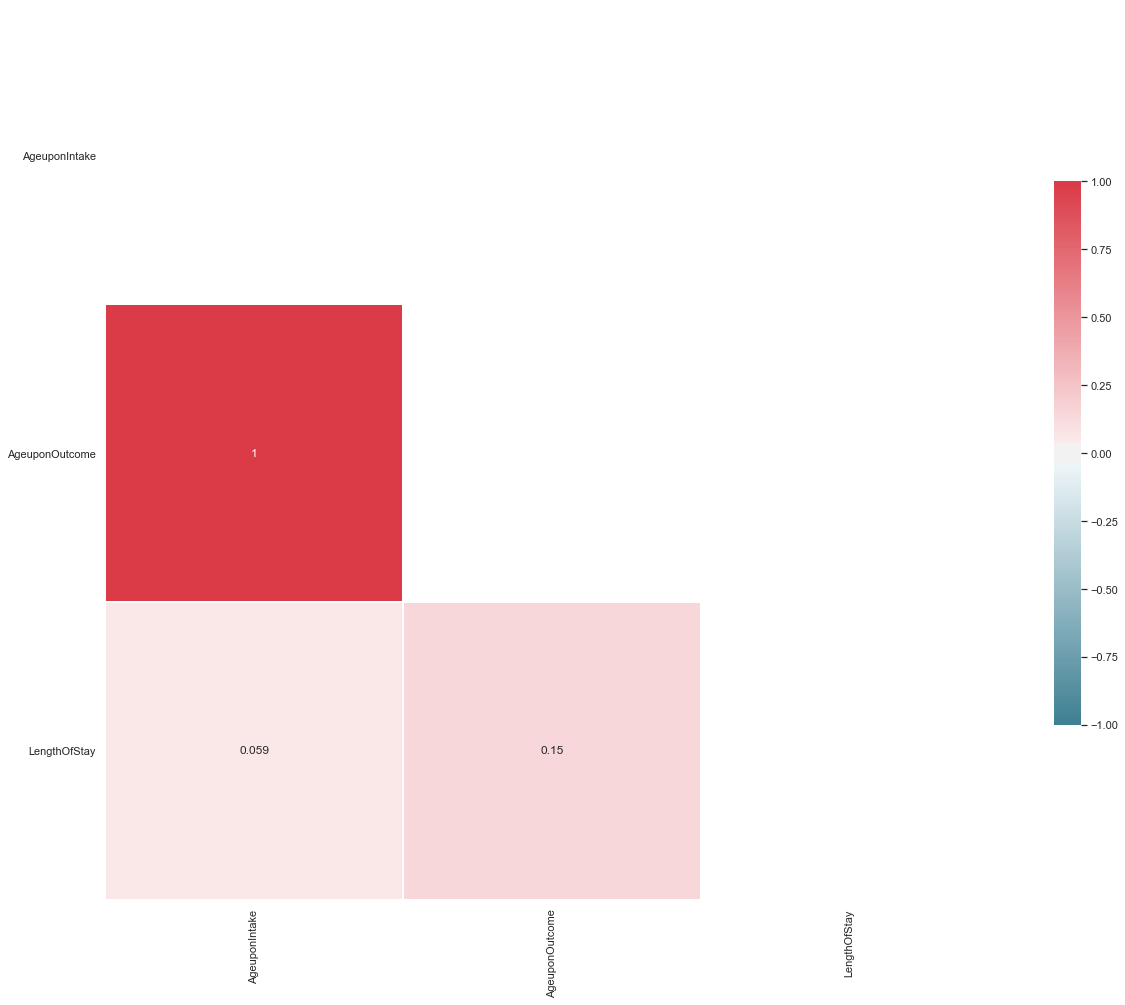

In [55]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

We can see the following in the above correlation matrix: 
-  *AgeUponIntake* and *AgeUponOutcome* have an extremely high correlation of 1. This is an expected and indicates that only one of these features would need to be kept. 
-  Both *AgeUponIntake* and *AgeUponOutcome* are very weakly correlated with length of stay, with values of 0.059 and 0.15, respectively. 

#### 1.2.2 Plot correlation between continous features and target feature. 

- We will now loop over both continuous features and plot them against the target *binary_outcome*. 
- We will discuss our findings from these plots and choose a subset (if any) of the feature(s) which seem promising. 
- As we left the target feature as type int64 earlier, we do not need to convert it now for these scatter plots. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


,binary_outcome
AgeuponIntake,0.059184
AgeuponOutcome,0.054104
LengthOfStay,-0.051748


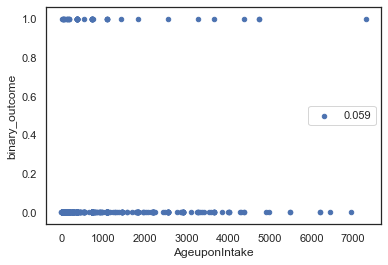

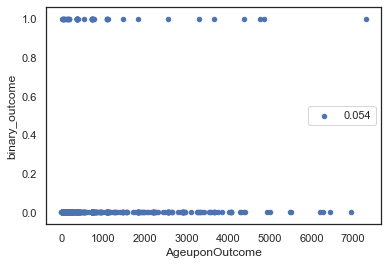

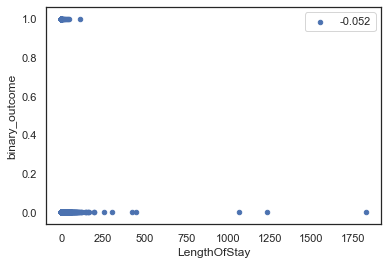

In [56]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_features]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "binary_outcome"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="binary_outcome", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['binary_outcome']).sort_values('binary_outcome', ascending=False)
corr_df

#### 1.2.2 Interpretation of the results

- We can see that there is no clearly defined correlation between either feature and the target feature.
- The result is surprising as it was expected that the age of an animal would have an effect on its outcome. 
- However, this result is perhaps explained by the large range of ages and the variety of animals which the ages represent. 
- The sorted correlation dataframes above the plots give an even clearer indication of the results. We can see that the correlation between *AgeUponIntake* and the target feature is 0.059 while the correlation between *AgeUponOutcome* and the target feature is 0.054.
- It must be noted however, that as described in section 3.6.1 of the FMLPD course textbook, continuous features that cover very different ranges should be normalised. As we are dealing with the ages of many different species of animals, normalisation would cause these two continous features to fall within a specified range while maintaining the relative differences between the values for the feature. In other words, adding a normalisation step would better represent the different between an old dog and an old racoon, for example. 
- At this stage in the assignment however, we are choosing the leave the ages at their absolute values. Later in the assignment we will have the option to implement normalisation and make a comparision.
- The correlation between *lengthOfStay* and the outcome is -0.052. This feature will be dropped as these results show that it is likely not an indicator of the binary outcome. 
- As a result, at this stage we will drop these two features as they do not look like good predictors of the target outcome. 

## TODO Investigating whether to normalise ages.........

In [57]:
# dict to hold correlation values 
# corr_dict = {}

# # plot pairwise interaction between all continuous features and target
# for column in X_train[X_train["AnimalType_Intake"]=="Cat"][continuous_features]:
#     # create temp df to merge column and target
#     df_temp = pd.concat([X_train[X_train["AnimalType_Intake"]=="Cat"][column], y_train], axis=1)
#     # store correlation in variable
#     correlation = df_temp[[column, "binary_outcome"]].corr().values[0,1]
#     # plot the column and tartget feature
#     df_temp.plot(kind='scatter', x=column, y="binary_outcome", label="%.3f" % correlation)
#     # add correlation to dict
#     corr_dict[column] = correlation

# # dataframe holding sorted correlation values to aid in interpreting results
# corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['binary_outcome']).sort_values('binary_outcome', ascending=False)
# corr_df

For now we will label the two continuous features as ```low_correlation_continuous_features``` and will remove them after analysing the categorical features. 

In [58]:
low_correlation_continuous_features = ['AgeuponIntake', 'AgeuponOutcome', 'LengthOfStay']

#### 1.2.3 Plot interaction between categorical features and target feature.

- We will now plot a pairwise interaction between each categorical feature and the target feature. 
- We will discuss which features seem to be better at predicting the target feature and will choose a subset of features we find promising.
- As with the plots of continuous features above, only the training dataset will be used. 
- To create these plots we will work with the variable *categorical_features* created above. 
- We will begin by converting the target feature to a categorical type as this is required for these plots. 

In [59]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")


 Name_Provided
Index 	 Count
No 	 212
Yes 	 488

 FoundLocation
Index 	 Count
Austin (TX) 	 575
Travis (TX) 	 63
Other 	 5
Outside Jurisdiction 	 6
Manor (TX) 	 15
Pflugerville (TX) 	 13
Del Valle (TX) 	 23

 IntakeType
Index 	 Count
Stray 	 495
Owner Surrender 	 133
Public Assist 	 48
Wildlife 	 23
Euthanasia Request 	 1

 IntakeCondition
Index 	 Count
Normal 	 622
Injured 	 33
Sick 	 30
Other 	 1
Nursing 	 14

 AnimalType_Intake
Index 	 Count
Cat 	 269
Dog 	 393
Bat 	 17
Other 	 16
Bird 	 5

 Breed_Intake
Index 	 Count
Pure Breed 	 169
Mixed Breed 	 531

 Color_Intake
Index 	 Count
Dark 	 369
Light 	 331

 ColorOriginal
Index 	 Count
Mixed Pattern 	 167
White 	 84
Brown Shades 	 165
Black 	 171
Other 	 77
Grey 	 12
Light Shades 	 24

 BreedOriginal
Index 	 Count
Domestic Shorthair 	 217
Domestic Longhair 	 9
Pit Bull 	 49
Other Dog Breeds 	 187
Labrador Retriever 	 45
Other Animal Breeds 	 38
Border Collie 	 8
Miniature Poodle 	 10
Chihuahua Shorthair 	 60
Other Cat Breeds 	 12
Dome

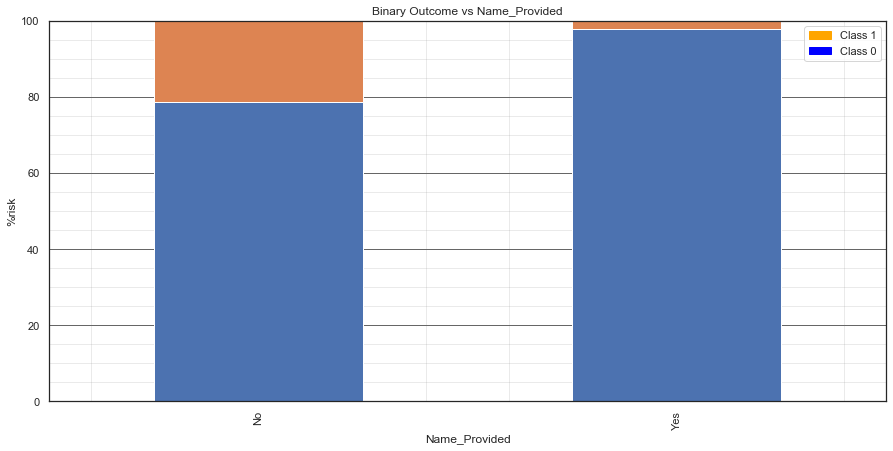

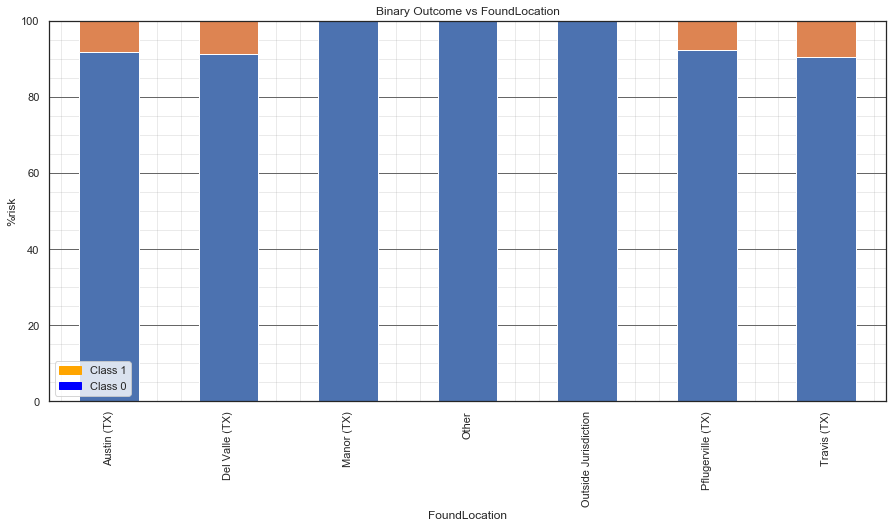

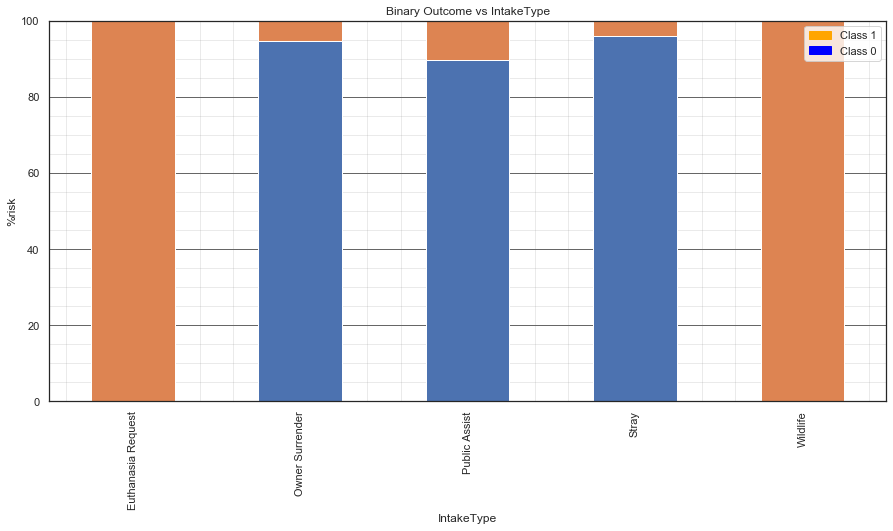

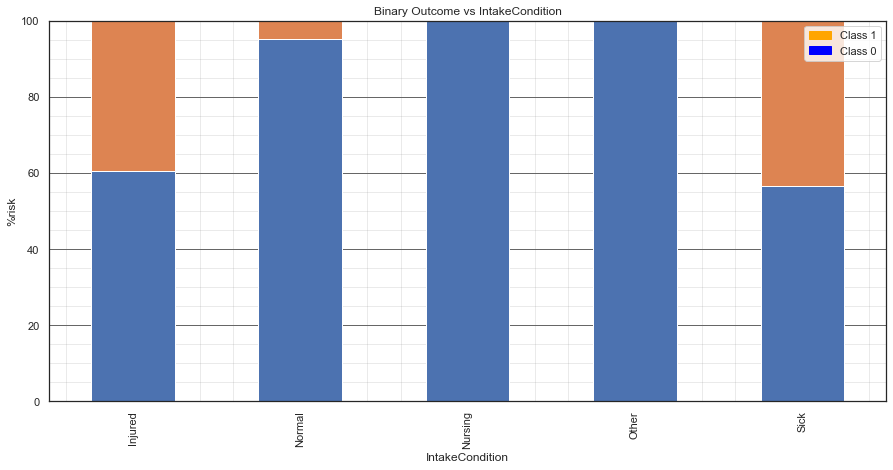

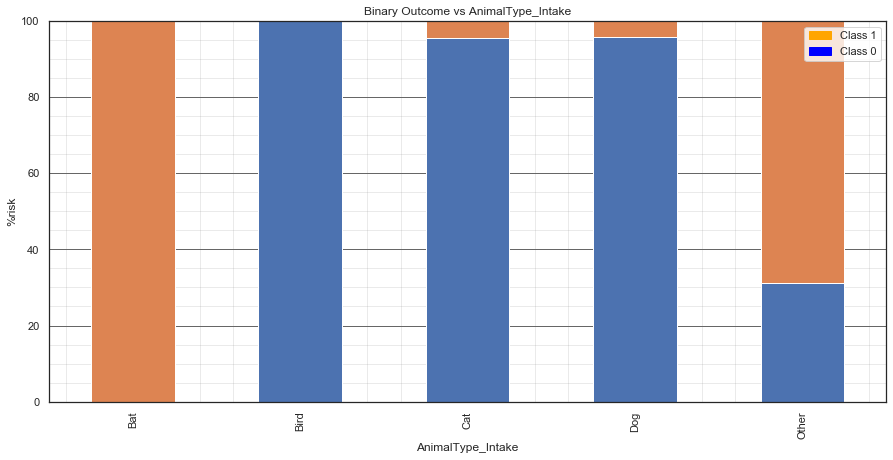

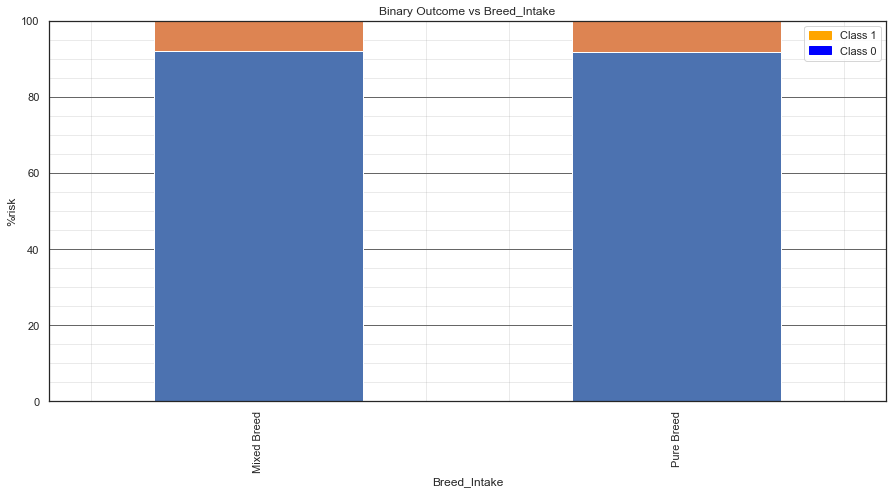

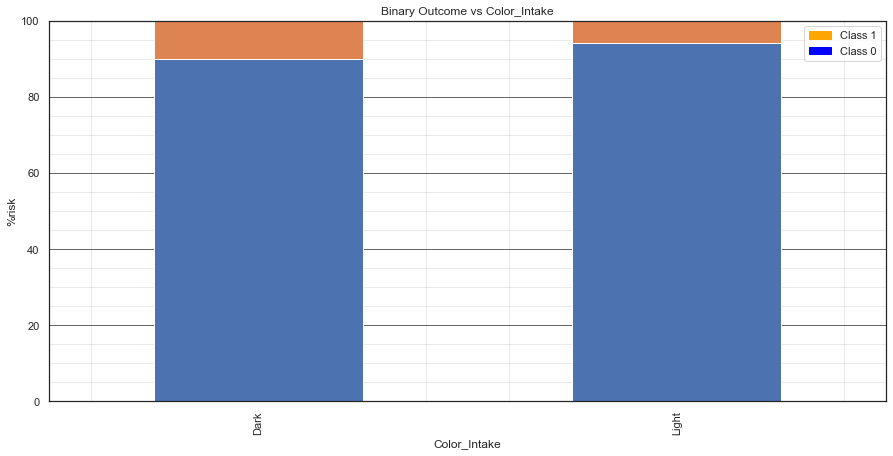

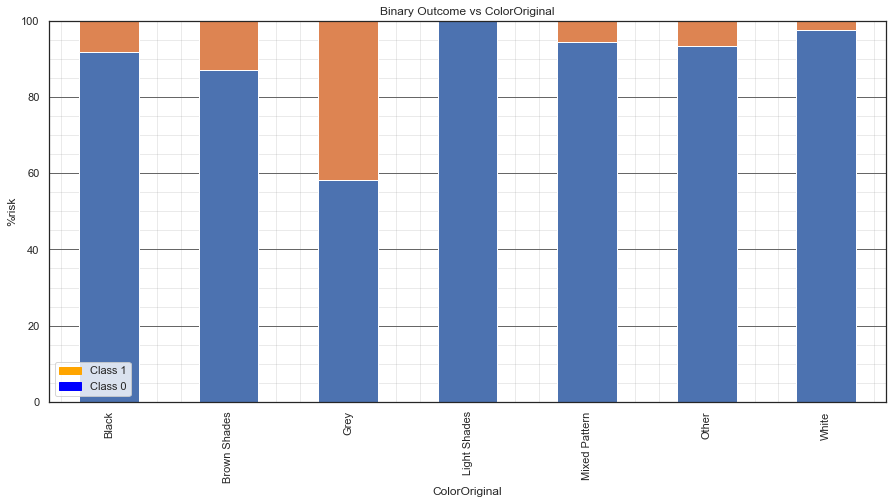

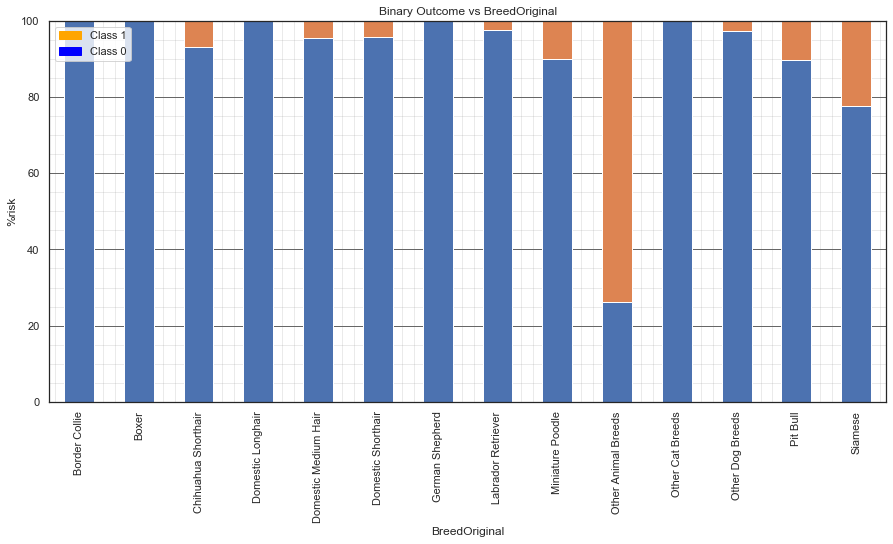

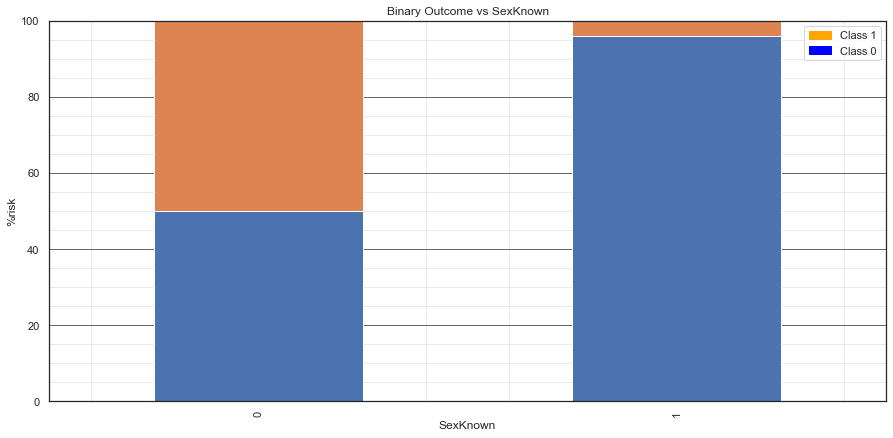

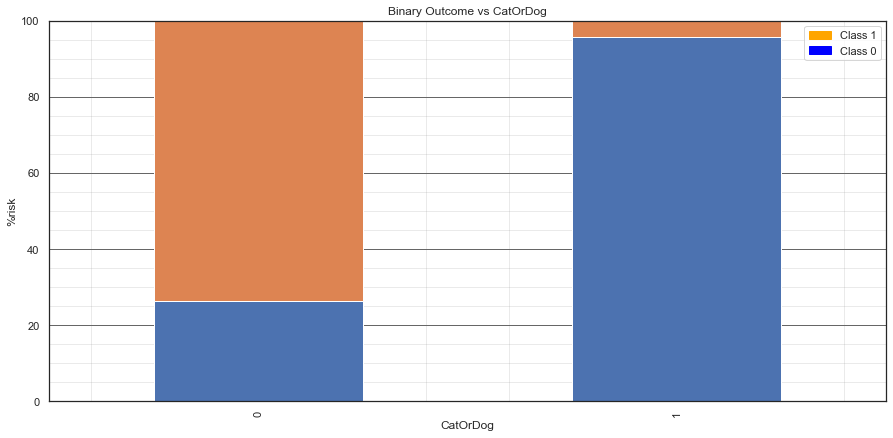

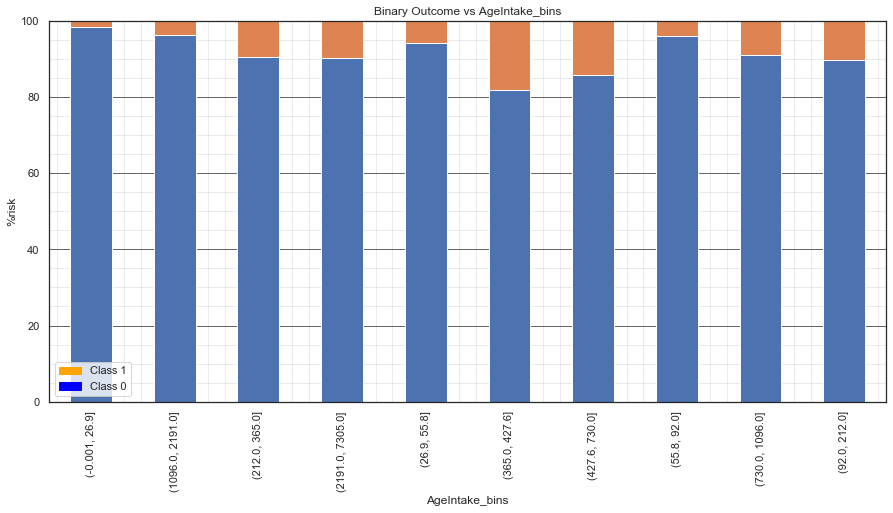

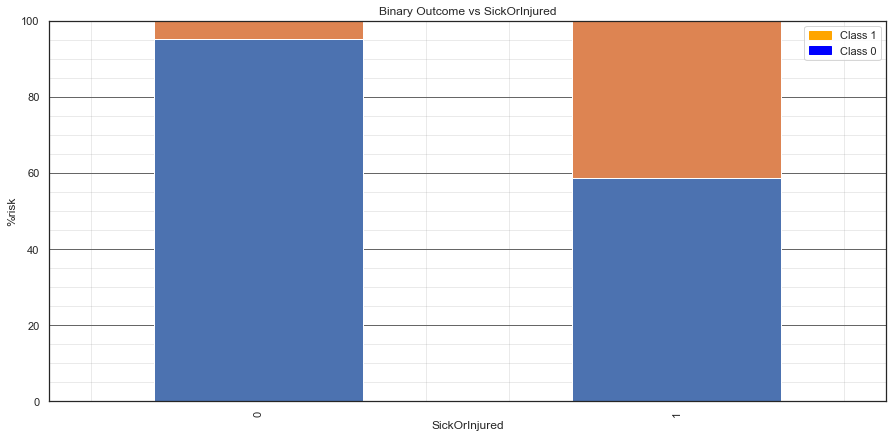

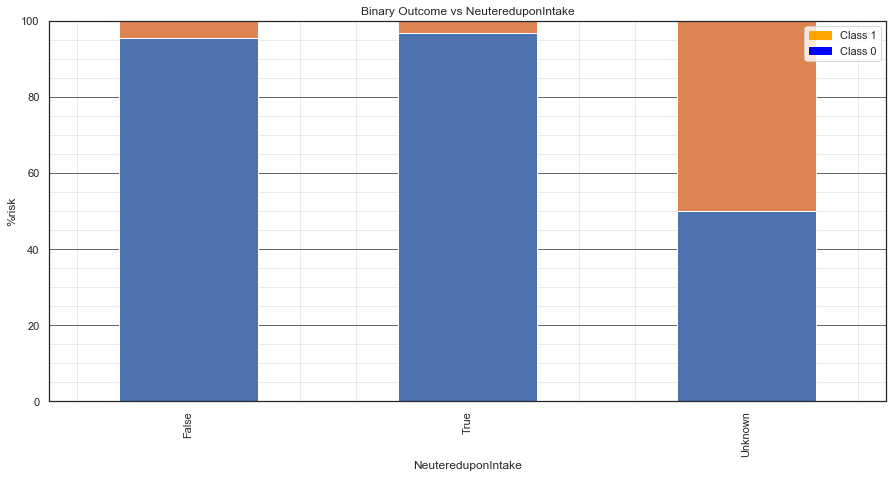

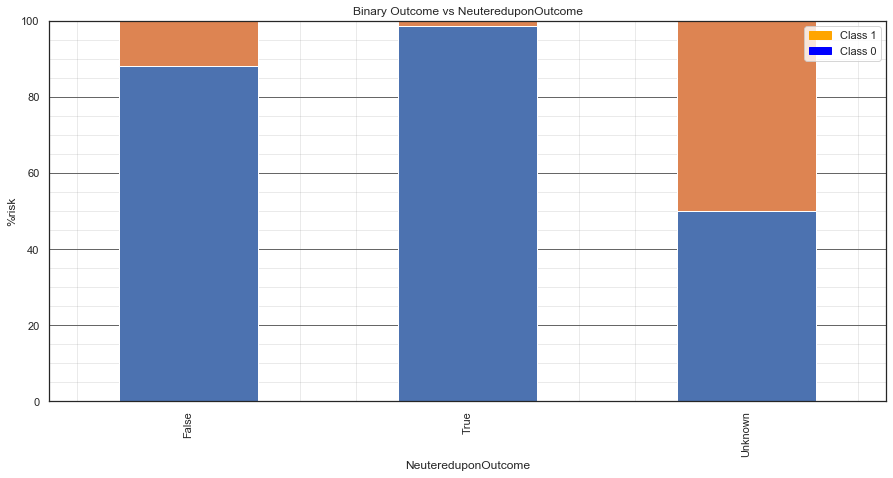

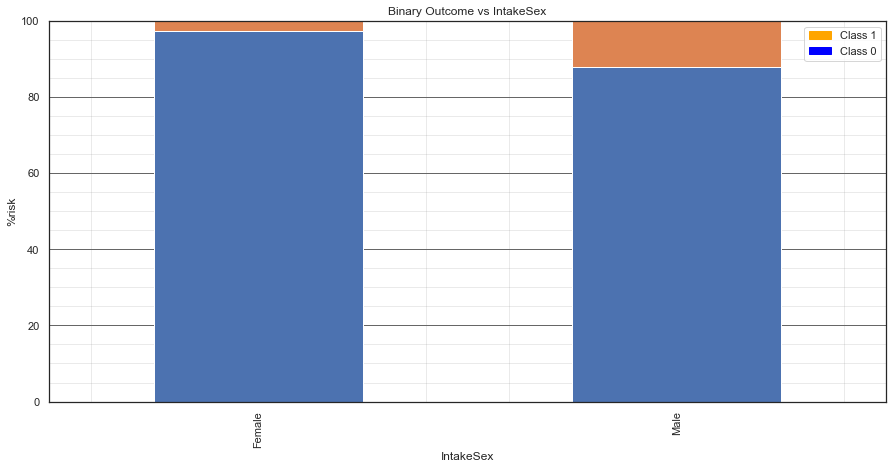

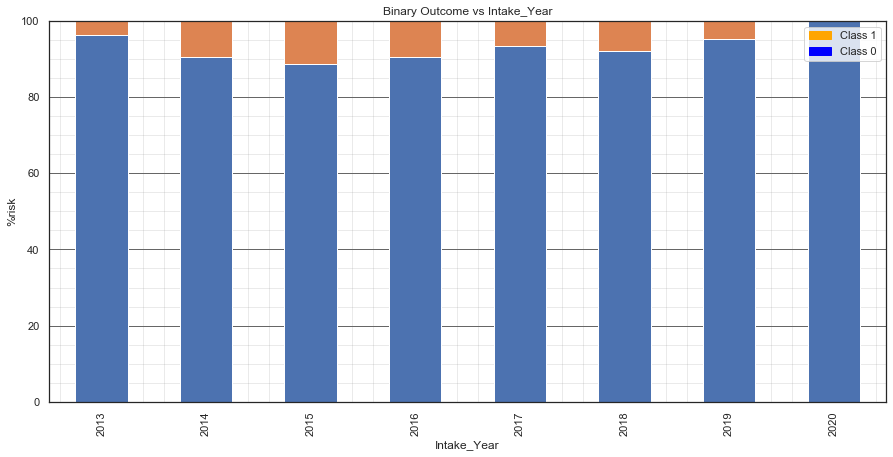

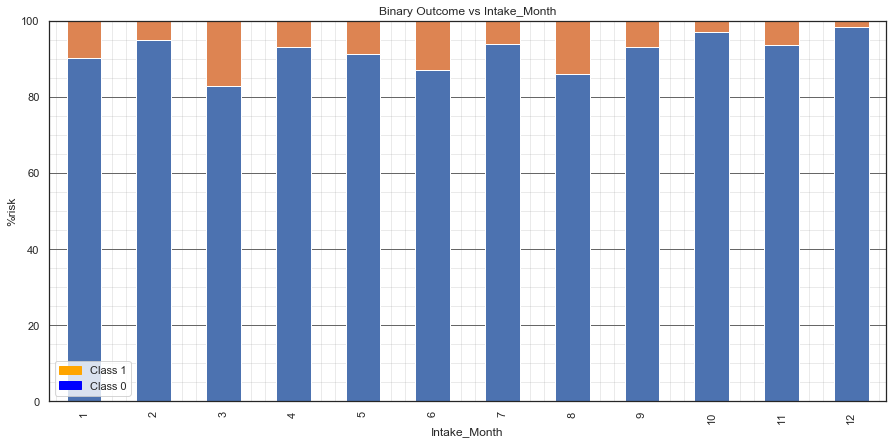

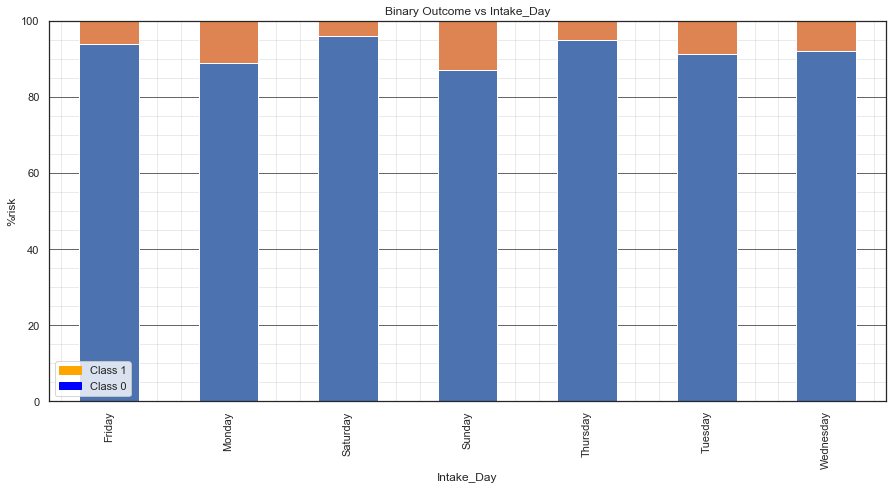

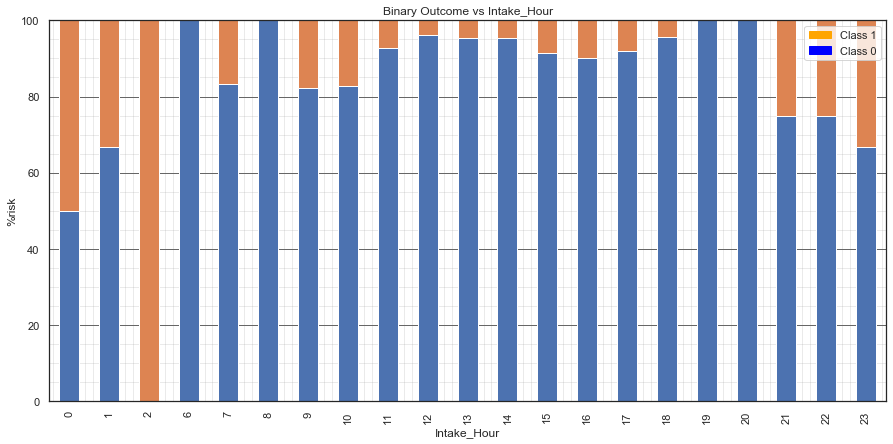

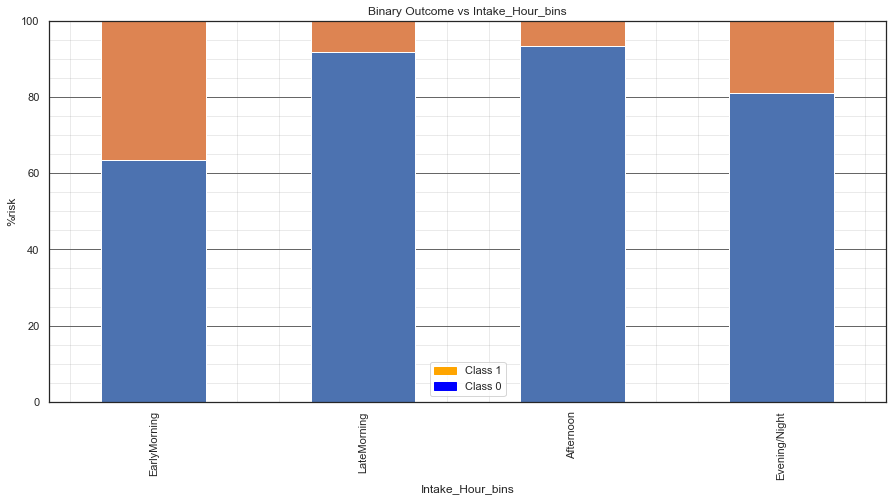

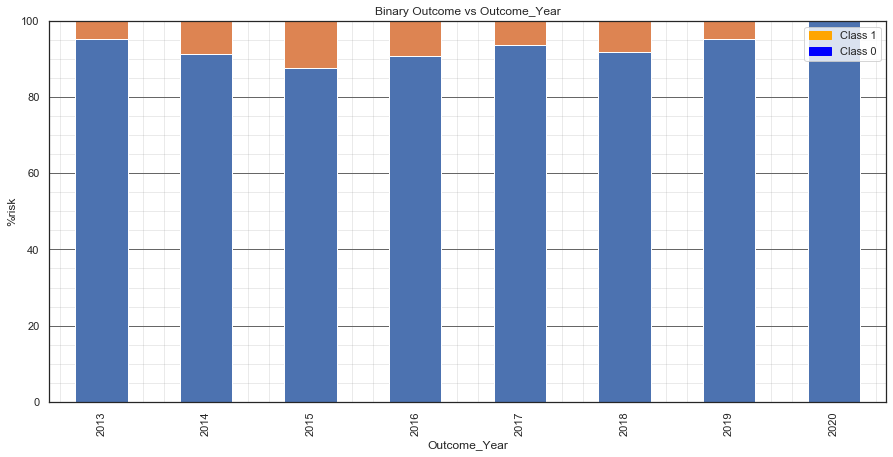

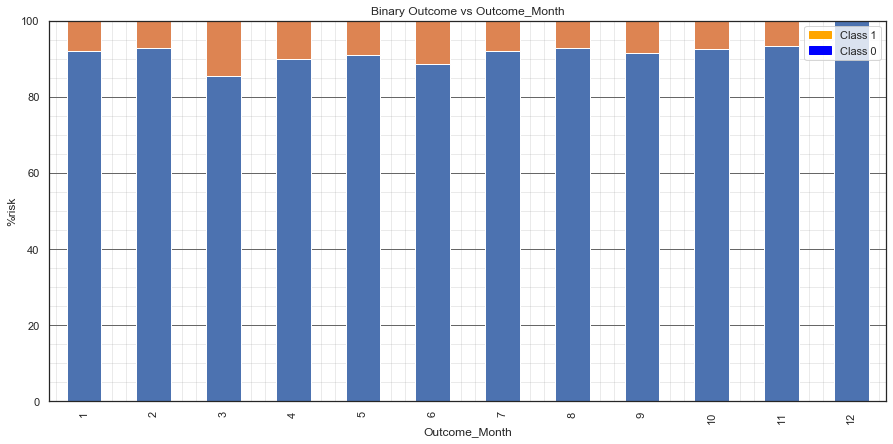

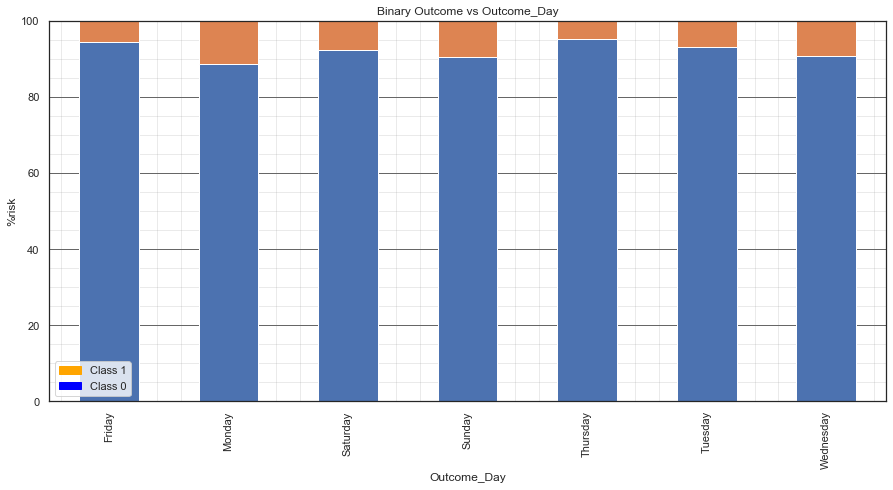

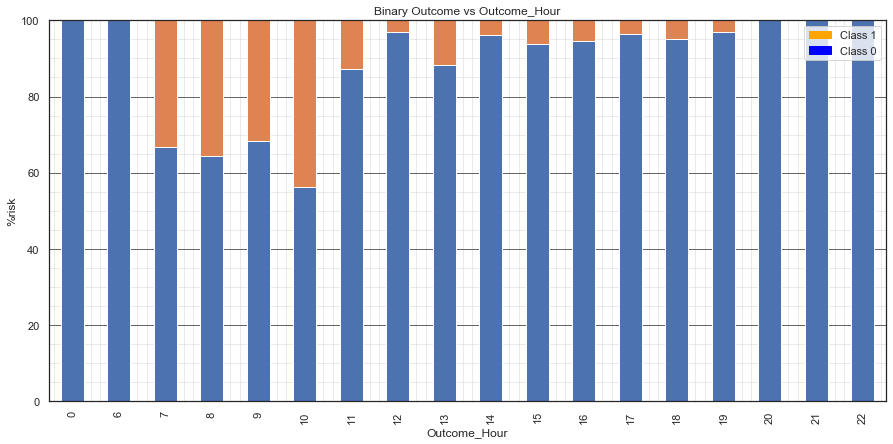

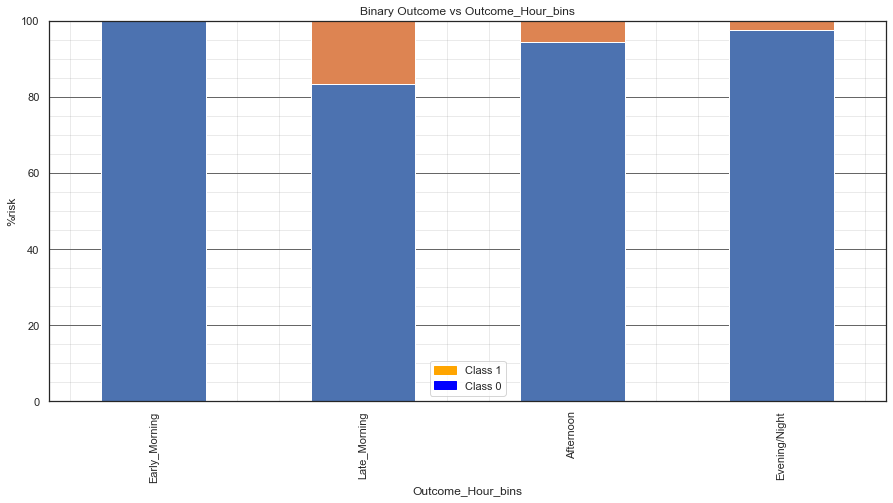

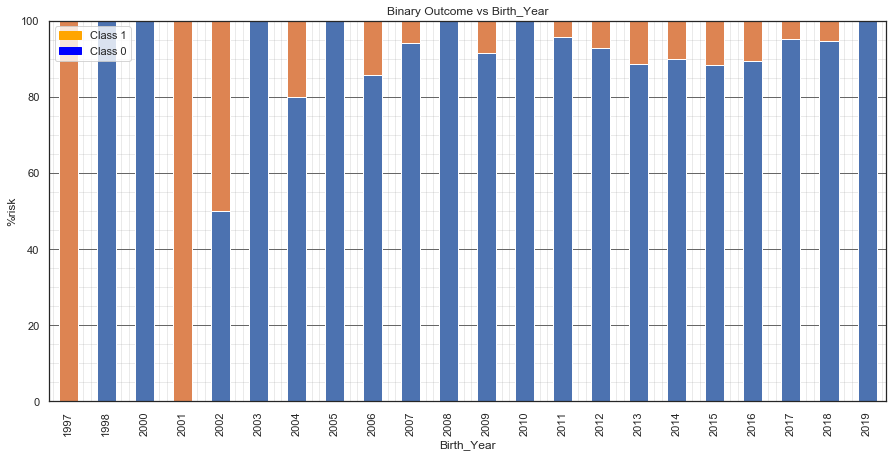

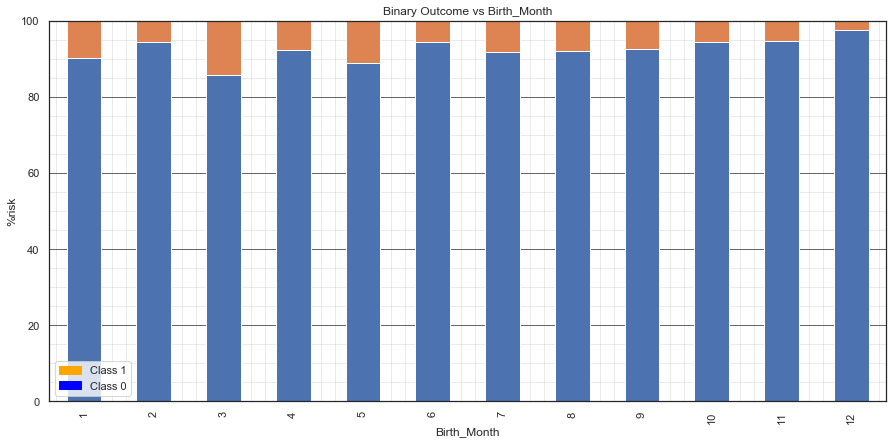

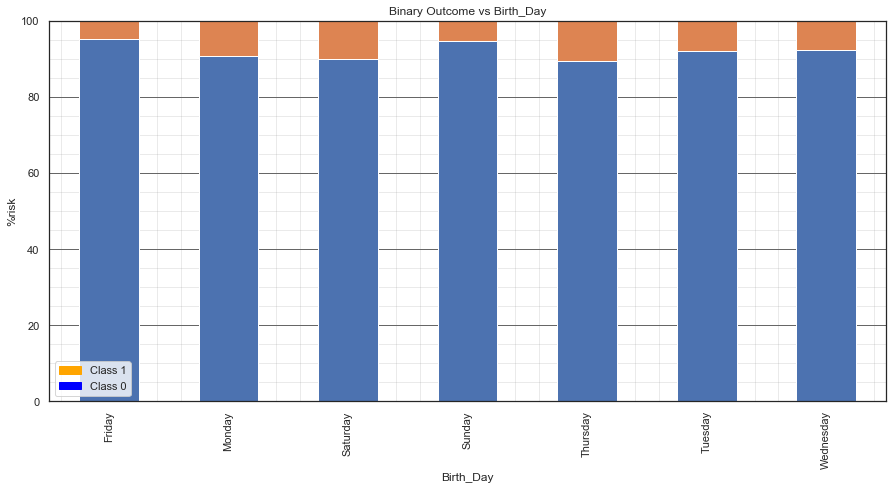

In [60]:
# X_train[categorical_features].columns

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)


# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_features:
    # Using code from the module lab

    values = pd.unique(df_temp[categorical_feature].ravel())

    # create percent column and initalise to 0
    df_temp['percent'] = 0

    #print header
    print("\n", categorical_feature)
    print("Index \t Count")

    # loop through each value in the feature col1
    for i in values:

        count = df_temp[df_temp[categorical_feature] == i].count()['binary_outcome']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'binary_outcome']].groupby([categorical_feature,'binary_outcome']).sum()

    #plot the results
    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"Binary Outcome vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='Class 1')
    blue_patch = mpatches.Patch(color='blue', label='Class 0')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines to make the plots easier to visualise
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    my_plot.set_xlabel(categorical_feature)
    my_plot.set_ylabel("%risk")
    my_plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

#### 1.2.4 Interpretation of the results

As we have a lot of categorical features, we will only give a brief discussion of each. 

- **Name_Provided**: During data cleaining in homework1, we converted the values of this feature to represent whether an animal has a name of not. We can see that animals with no name are 20% more likely to have a negative outcome. This feature will be kept. 

- **FoundLocation**: We can see that if an animal is found in Austin, Del Valle, Pflugerville or Travis, they are 5-10% more likely to have a negative outcome than if found at the other locations. In fact, we see no negaitve outcome at any other locations. Upon examination of the counts however, we can see that this is most likely due to the cities mentioned having much larger value counts. This feature will be dropped.

- **Intake_Type**: We can see here that intake type has some interesting findings. As expected, all euthenasia requests result in a negative outcome. Interestingly, all animals with intake type *Wildlife* also have a negative outcome. This feature will be kept. 

- **IntakeCondition**: Here we can see that if an animal is sick or injured, they are 40-50% more likely to have a negative outcome. Although when looking at the absolute values, we can see that the sick or injured animals only make up approximately 10% of the total, the graphs show that this feature still seems like a strong predictor. This was accounted for in homework1 with the new feature *SickOrInjured*. 

- **AnimalType_Intake**: We see in this plot that animals of type *Bat* or *Other* are 100% and 65% more likely to have a negative outcome, respecitvely, than animals of type *Bird, Cat* or *Dog*. On further inspection of the value counts however, we can see that there are only 5 birds. Thus, it seems that animals of type *Cat* and *Dog* are most likely to have a positive outcome. This is accounted for in the new feature *CatOrDog* made in homework1. 

- **IntakeSex:** We can see that males are approximately 10% more likely to be in class 1 than females. This feature will be kept. 

- **NeutereduponIntake, NeutereduponOutcome** We can see that there is a strong correlation between the value unknown and class 1. We can also see a small correlation between animals not being neutered upon outcome and class 1. These two features are providing very similar information, with *NeutereduponOutcome* providing additional information. As a result, we will drop *NeutereduponIntake* and keep *NeutereduponOutcome*.

- **BreedOriginal**: We can see that breeds of other animals are more likely to have a negative outcome. This is unsurprising after analysing the *AnimalType_Intake* plot and seeing that cats and dogs are most likely to have a positive outcome. We can also see some small correlations between other breeds and the binary outcome. For example, *Pit Bull* and *Poodle* dogs both have are more likely to be in class 1 than other breeds. Similarly, we can see that *Siamese* cats are more likely to have a negative outcome than other cat breeds. As a result, this feature will be kept. 

- **ColorOriginal**: We can see some small correlations here. *Grey/Silver* has the worst outcome while *White* and *LightColour* animals are most likely to be class 0. This feature will be kept. 

- **Breed_Intake, Color_Intake**: Neither of these show any correlation with the outcome and shall both be dropped. 

**new features created in homework1**:
- **SexKnown**: Upon further analysis since creating this feature in homework1, we have found that this feature is not helpful and will be dropped. 
- **CatOrDog, SickOrInjured**: Both of these new features show a strong correlation with the binary outcome and will both be kept. 
- **AgeIntake_bins**: We can see that there is no clear pattern between the age of intake bins and the binary outcome. It was expected that older animals would be more likely to have a negative outcome due to both a higher likelihood of death and a lower likelihood of being adopted. However, we can see that the greatest likelihood of a negative outcome is actually seen in the bin representing an age of 365-427 days. The likelihood of a negative outcome then decreases as the ages increase. This feature will be dropped. 

**Year, Month, Day, and hour features**:

Categorical features were created for each of the datetime features above. As there are too many to discuss, we will discuss only the ones for which we see a correlation.
- **Intake_Hour** is interesting. It seems that there is a much higher likelihood of a negative outcome if the animal is taken into the shelter during the night, with intake at 2am having a 100% likelihood of a negative outcome. On further investigation we can see that the number of animals being dropped in at these times is very low compared to the daylight hours. However, after doing some research into the Austin Animal center, I have learned that the opening hours are 11am-7pm. This information increases the relevance of the results seen during the night, as it is expected that the animals will not have as good an outcome if found or left at the shelter outside opening hours.
- **Intake_Hour_bins:** As expected, the information in *Intake_Hour* is well represented in this feature. We can see that an animal that enters the shelter in the early morning (0-6am) has a 30% likelihood of being in class 1 and an animal entering the shelter in the evening/night (6pm-midnight) has a 20% likelihood of being in class 1. These findings are in comparison to the other two values which show a 5-10% likelihood of the animal being in class 1. This feature can be kept and **Intake_Hour** can be dropped.
- **Outcome_Hour**: We can see that between 7-10am, animals have a higher likelihood of being in class 1. This is most likely due to animals who have died overnight being found in the morning once the shelter opens. This feature will be kept.
- **Outcome_Hour_bins:** As expected, we can see that animals with a time of outcome in the late morning have a higher likelihood of a negative outcome. This feature will be kept and **Outcome_Hour** will be dropped. 
- **All other datetime related features**: For all other features created from the datetime features, no clear correlation was found upon analysis of the plots and the value counts. These will be dropped. 

#### 1.2.5 Summary and drop features

From continuous vs target feature plots (1.2.1) we saw that none of the continious features showed a high correlation with the target feature. These features will be dropped. 
 
From categorical vs target feature (1.2.3) we saw that the following features did not show a clear relationship with the target feature and can be removed for now:

    - FoundLocation
    - Breed_Intake
    - ColorIntake
    - Intake_Year
    - Intake_Month
    - Intake_Day
    - Intake_Hour
    - Outcome_Year
    - Outcome_Month
    - Outcome_day
    - Outcome_Hour
    - Birth_Year
    - Birth_Month
    - Birth_Day
    - AnimalType_Intake
    - IntakeCondition
    - SexKnown
    - NeutereduponOutcome
    - AgeIntake_Bins


We will leave all other categorical features in for now. 

We will now create a list of the low information categorical features listed above. 

In [61]:
low_information_gain_categorical_features = ['FoundLocation','Breed_Intake', 'Color_Intake','Intake_Year', 'Intake_Month', 'Intake_Day', 'Intake_Hour', 'Outcome_Year', 'Outcome_Month', 'Outcome_Day', 'Outcome_Hour', 'Birth_Year', 'Birth_Month', 'Birth_Day', 'SexKnown', 'AnimalType_Intake', 'IntakeCondition', 'AgeIntake_bins', 'NeutereduponOutcome']

We will now drop the low impact categorical features listed above. 

- Before dropping we will duplicate the original dataframe *df* and label the duplicate as *df_version1*
- We will drop features from the duplicate *df_version1* only.
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset *df_version1* with the original dataset *df*.


In [62]:
df.dtypes

Name_Provided          category
FoundLocation          category
IntakeType             category
IntakeCondition        category
AnimalType_Intake      category
AgeuponIntake             int64
Breed_Intake           category
Color_Intake           category
AgeuponOutcome            int64
binary_outcome            int64
ColorOriginal          category
BreedOriginal          category
SexKnown               category
CatOrDog               category
AgeIntake_bins         category
SickOrInjured          category
NeutereduponIntake     category
NeutereduponOutcome    category
IntakeSex              category
Intake_Year            category
Intake_Month           category
Intake_Day             category
Intake_Hour            category
Intake_Hour_bins       category
Outcome_Year           category
Outcome_Month          category
Outcome_Day            category
Outcome_Hour           category
Outcome_Hour_bins      category
Birth_Year             category
Birth_Month            category
Birth_Da

In [63]:
low_value_features = list(set(low_correlation_continuous_features + low_information_gain_categorical_features))
# before dropping make copy of original
df_version1 = df.copy()
# drop low value features
df_version1.drop(low_value_features, 1, inplace=True)
print('\nRemaining columns:', df_version1.columns)
print('\nNew shape:', df_version1.shape)


Remaining columns: Index(['Name_Provided', 'IntakeType', 'binary_outcome', 'ColorOriginal',
       'BreedOriginal', 'CatOrDog', 'SickOrInjured', 'NeutereduponIntake',
       'IntakeSex', 'Intake_Hour_bins', 'Outcome_Hour_bins'],
      dtype='object')

New shape: (1000, 11)


### 1.3 Prepare the dataset for modelling

Now we have picked our descriptive features for the whole dataset, we will now carry out a number of additional steps in order to prepare the dataset for modelling: 
- Convert the categorical variables into dummies variables so that they can be used for modelling.
- Remove the redundant dummies which contain no additional information.
- Set up up the train test split again based on the dataset with the dummies included.

We will now go through these steps in more detail. 

Firstly, as described in section 7.4.3 of the course textbook 'Fundamentals of Machine Learning for Predictive Data Analytics', the most common approach to handling categorical features in regression models is to use a transformation that converts a single categorical feature into a number of continuous features that can encode the levels of the categorical feature. The levels of the categorical feature are encoded by setting the value of the new continuous feature which corresponds to the level of the categorical feature to 1, and the other continious features to 0. This is known as *dummy encoding* and is the approoach we will now take. 

The downside of this approach however, is that it creates a lot of new features in the dataset. In other words, as we will see in the linear regression steps below, it creates many new weights for which optimal values must be found. For this reason we carry out the second step above - remove the redundant dummies which contain no additional information. For example, we can assume that a zero in all new features implies that the original cateogrical feature had the first value. We will add the parameter *drop_first = True* in the code below in order to execute this step. 

In [64]:
# set up dummies features
df_version1 = pd.get_dummies(df_version1, drop_first=True)

In [65]:
#look at the dummies 
df_version1.head()

,binary_outcome,Name_Provided_Yes,IntakeType_Owner Surrender,IntakeType_Public Assist,IntakeType_Stray,IntakeType_Wildlife,ColorOriginal_Brown Shades,ColorOriginal_Grey,ColorOriginal_Light Shades,ColorOriginal_Mixed Pattern,...,SickOrInjured_1,NeutereduponIntake_True,NeutereduponIntake_Unknown,IntakeSex_Male,Intake_Hour_bins_LateMorning,Intake_Hour_bins_Afternoon,Intake_Hour_bins_Evening/Night,Outcome_Hour_bins_Late_Morning,Outcome_Hour_bins_Afternoon,Outcome_Hour_bins_Evening/Night
0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


**The features are:**

As we are not keeping any of our continuous features for now, our features are comprised only of the *uint8* types generated when making dummies above.

In [66]:
#put all features together into a variable
features = df_version1.select_dtypes(include=['uint8']).columns.tolist()
features

['Name_Provided_Yes',
 'IntakeType_Owner Surrender',
 'IntakeType_Public Assist',
 'IntakeType_Stray',
 'IntakeType_Wildlife',
 'ColorOriginal_Brown Shades',
 'ColorOriginal_Grey',
 'ColorOriginal_Light Shades',
 'ColorOriginal_Mixed Pattern',
 'ColorOriginal_Other',
 'ColorOriginal_White',
 'BreedOriginal_Boxer',
 'BreedOriginal_Chihuahua Shorthair',
 'BreedOriginal_Domestic Longhair',
 'BreedOriginal_Domestic Medium Hair',
 'BreedOriginal_Domestic Shorthair',
 'BreedOriginal_German Shepherd',
 'BreedOriginal_Labrador Retriever',
 'BreedOriginal_Miniature Poodle',
 'BreedOriginal_Other Animal Breeds',
 'BreedOriginal_Other Cat Breeds',
 'BreedOriginal_Other Dog Breeds',
 'BreedOriginal_Pit Bull',
 'BreedOriginal_Siamese',
 'CatOrDog_1',
 'SickOrInjured_1',
 'NeutereduponIntake_True',
 'NeutereduponIntake_Unknown',
 'IntakeSex_Male',
 'Intake_Hour_bins_LateMorning',
 'Intake_Hour_bins_Afternoon',
 'Intake_Hour_bins_Evening/Night',
 'Outcome_Hour_bins_Late_Morning',
 'Outcome_Hour_bins_

### Train/test split
- We will now split the dataset into train/test subsets using the dummy values created above.
- As explained in section 1.1 above, we will use stratified sampling.
- The target *binary_outcome* is stored in dataframe "y".
- The remaining features are stored in dataframe "X".
- Both are split into training and test subsets.

In [67]:
#set up x and y 
y = df_version1['binary_outcome']
X = df_version1.drop(["binary_outcome"],1)

In [68]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1, stratify=y)

print("original range is: ",df_version1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

print("\nTarget feature binary_outcome total dataset counts:\n\n", y.value_counts())
print("\nTraining data binary_outcome counts:\n", y_train.value_counts())
print("\nTest data binary_outcome counts:\n", y_test.value_counts())

original range is:  1000
training range (70%):	 rows 0 to 700
test range (30%): 	 rows 700 to 1000

Target feature binary_outcome total dataset counts:

 0    920
1     80
Name: binary_outcome, dtype: int64

Training data binary_outcome counts:
 0    644
1     56
Name: binary_outcome, dtype: int64

Test data binary_outcome counts:
 0    276
1     24
Name: binary_outcome, dtype: int64


Again, as we have used stratified sampling, we can see that the ratio of positive to negative outcome is equal in all splits. 

We will now look at the first five lines of the training and test subsets. 

In [69]:
print("\nDescriptive features in X_train:\n", X_train.head(5))
print("\nTarget feature in y_train:\n", y_train.head(5))
print("\nDescriptive features in X_test:\n", X_test.head(5))
print("\nTarget feature in y_test:\n", y_test.head(5))


Descriptive features in X_train:
      Name_Provided_Yes  IntakeType_Owner Surrender  IntakeType_Public Assist  \
400                  0                           0                         0   
55                   1                           0                         0   
777                  0                           0                         0   
329                  1                           1                         0   
196                  1                           1                         0   

     IntakeType_Stray  IntakeType_Wildlife  ColorOriginal_Brown Shades  \
400                 1                    0                           0   
55                  1                    0                           0   
777                 1                    0                           0   
329                 0                    0                           0   
196                 0                    0                           0   

     ColorOriginal_Grey  ColorOriginal_

#### Reset the indexes of the training and test splits
- We can see from the output above that the indexes are no longer consecutive for any of the dataframes. 
- We will fix this now so that we are able to merge the dataframes later in the assignment.

In [70]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,Name_Provided_Yes,IntakeType_Owner Surrender,IntakeType_Public Assist,IntakeType_Stray,IntakeType_Wildlife,ColorOriginal_Brown Shades,ColorOriginal_Grey,ColorOriginal_Light Shades,ColorOriginal_Mixed Pattern,ColorOriginal_Other,...,SickOrInjured_1,NeutereduponIntake_True,NeutereduponIntake_Unknown,IntakeSex_Male,Intake_Hour_bins_LateMorning,Intake_Hour_bins_Afternoon,Intake_Hour_bins_Evening/Night,Outcome_Hour_bins_Late_Morning,Outcome_Hour_bins_Afternoon,Outcome_Hour_bins_Evening/Night
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,1,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
4,1,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,1,0,0,1,0


We are now ready to model the datasets.

## 2) Linear Regression

#### 2.1) On the training set, train a linear regression model to predict the target feature, using only the descriptive features selected in exercise (1) above.

In [71]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

#### (2.2) Print the coefficients learned by the model and discuss their role in the model.


In [72]:
#Print out the weights that have been learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['Name_Provided_Yes', 'IntakeType_Owner Surrender',
       'IntakeType_Public Assist', 'IntakeType_Stray', 'IntakeType_Wildlife',
       'ColorOriginal_Brown Shades', 'ColorOriginal_Grey',
       'ColorOriginal_Light Shades', 'ColorOriginal_Mixed Pattern',
       'ColorOriginal_Other', 'ColorOriginal_White', 'BreedOriginal_Boxer',
       'BreedOriginal_Chihuahua Shorthair', 'BreedOriginal_Domestic Longhair',
       'BreedOriginal_Domestic Medium Hair',
       'BreedOriginal_Domestic Shorthair', 'BreedOriginal_German Shepherd',
       'BreedOriginal_Labrador Retriever', 'BreedOriginal_Miniature Poodle',
       'BreedOriginal_Other Animal Breeds', 'BreedOriginal_Other Cat Breeds',
       'BreedOriginal_Other Dog Breeds', 'BreedOriginal_Pit Bull',
       'BreedOriginal_Siamese', 'CatOrDog_1', 'SickOrInjured_1',
       'NeutereduponIntake_True', 'NeutereduponIntake_Unknown',
       'IntakeSex_Male', 'Intake_Hour_bins_LateMorning',
       'Intake_Hour_bins_Afternoon',

#### Discussion: 

Before discussing the weights printout out above, we will first introduce linear regression. 

- Linear regression is a supervised machine learning method which is used to make predictions based on a linear relationship between the target (dependent variable) and any number of independent variables (also known as predictors).
- It finds the line of best fit that describes the relationship between the target and predictors. 
- The linear regression formula takes the following form:
    - $target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $
    
- In the formula, w_0, w_1 etc are known as the **model coefficients**. 
- To create the predictive model using linear regression, these coefficients must be "learned". 
- As seen in the image below, this is usually done using the **least squares criterion**. In other words, we find the line of best fit that describes the relationship between the target and predictors which minimises the **sum of squared residuals** (also known as sum of squared errors).
<br><img src="linear_regression.png" style="width: 300px;"/> <br>
Source: https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb

- We will now understand the image above: 
    - The **black** dots are the observed values of x and y.
    - The **blue line** is the least squares line. 
    - The **red lines** are the residuals. These are the distances between the observed values and the least squares line. It is these residuals that we try to minimise in linear regression.
    
- Linear regression is a regression task, which means that it predicts a numeric target feature. Thus, the output from the formula above is a continuous value that can be less than 0 and higher than 1.
- It is important to note one of the downfalls of linear regression is that it is sensitive to outliers. However, this does not apply to our categorical features. 

**Discussing the coefficients learned by the model:**
- We can see above that the intercept is 1.03 (this is w_0 in the formula above). This is the value of y when x is zero. In other words it is where the model intercepts the x axis. 
- If all other coefficients were zero, the model result would be 1.03.
- We can see the coefficients for each feature above. They are zipped together in a single list for ease of visualisation and interpretation.
- All of our features are categorical features which are dummy coded. Thus, care needs to be taken when interpreting the coefficients. The first value of each feature (which we have dropped) is the reference and each dummy is compared to the reference.
- For example, we see that Name_Provided_Yes decreases by 0.086%. This makes sense as we saw in our barplot above that animals with no name are more likely to be in class 1.

**Classification problem**
- We are trying to solve a classification problem and thus it is important to note that the output from a linear regression model is not suited to this type of problem.
- The output we get from linear regression is a numeric value and is not a probability. As a result, we will need to perform a thresholding step in order to convert the output into a binary classification. 
- The threshold will be as follows: 
    - Any values >= 0.5 will be cast to 1
    - Any values <0.5 will be cast to 0

#### 2.4 Printing 10 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 10 training examples. 
- As discussed above, we will now threshold the predicted target feature value given by the linear regression model at 0.5. This will give us the predicted class. 

In [73]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   binary_outcome  Predicted
0               0        0.0
1               0        0.0
2               0        0.0
3               0        0.0
4               0        0.0
5               1        0.0
6               0        0.0
7               0        0.0
8               0        0.0
9               0        0.0


#### 2.5 Evaluation metrics based on training data
- We will now print the classification evaluation measures computed on the training set. These are:
    - Accuracy
    - Precision
    - Confusion Matrix
    - Recall
    - F1
- We will then discuss our findings.

In [74]:
#print evaluation measures
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9528571428571428
Confusion matrix: 
 [[643   1]
 [ 32  24]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      1.00      0.97       644
           1       0.96      0.43      0.59        56

    accuracy                           0.95       700
   macro avg       0.96      0.71      0.78       700
weighted avg       0.95      0.95      0.94       700



#### Interpretation of results

We will now explain what each of the measures above means and will discuss our results. 

- **Accuracy** tell us how often the model is correct. 
    - We have an accuracy of 95%
- **Confusion Matrix** tells us the following:
    - [0][0] TRUE NEGATIVE - The number predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number predicted 1 that is actually 1
    - We can see that we have 32 false negatives. This is quite a high value. 
- **Precision** tells us the following"
    - What percentage of the predicted positive values are actually positive.
    - How good the model is at predicting the positive class.
    - It is the number of values which were correctly predicted positive over the total number of positive values.
    - Our precision negative is 0.95
    - Our precision positive is 0.96
- **Recall** tells us what % of the positive values we succesfully predicted.
    - It is the number of values which were correctly predicted positive over the total number of positive values. 
    - Our recall negative is 1.00.
    - Our recall positive is 0.43. This low result is due to the large number of false negatives mentioned above. 
- **F1 Score** is a weighted average of precision and recall. 
    - Our F1 score negative is 0.97.
    - Our F1 score positive is 0.59.
    
**Summary**
- Some of the results are quite good. 
- However, the positive recall is quite low. We can see that the model is better at predicting the negative class. 
- This makes sense considering that the majority class is the negative class. As a result, the model has more negative data to learn from. 

#### 2.6 Evaluate the model using the hold-out (30% examples) test set
- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

In [75]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(20))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0                0        0.0
1                0        0.0
2                0        0.0
3                0        0.0
4                0        0.0
5                0        0.0
6                0        0.0
7                1        0.0
8                1        1.0
9                0        0.0
10               0        0.0
11               0        0.0
12               0        0.0
13               0        0.0
14               0        0.0
15               0        0.0
16               0        0.0
17               0        0.0
18               0        0.0
19               0        0.0


##### Evaluation metrics based on test data

In [76]:
# print evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9533333333333334
Confusion matrix: 
 [[275   1]
 [ 13  11]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.95      1.00      0.98       276
           1       0.92      0.46      0.61        24

    accuracy                           0.95       300
   macro avg       0.94      0.73      0.79       300
weighted avg       0.95      0.95      0.95       300


==================== Train Data ======================
Accuracy:  0.9528571428571428
Confusion matrix: 
 [[643   1]
 [ 32  24]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.95      1.00      0.97       644
           1       0.96      0.43      0.59        56

    accuracy                           0.95       700
   macro avg       0.96      0.71      0.78       700
weighted avg       0.95      0.95      0.94       700



#### Interpretation of test results and comparison with training set

We will now discuss the results for the test data and compare it to the training data.
- **Accuracy:** 
    - The accuracy of both the training and test data are 95%.
- **Precision:** 
    - The precision score for predicting the negative class is also 95%.
    - The precision score for predicting the positive class has decreased from 96% to 92%.
- **Recall:**
    - The recall score for predicting the negative class is the same at 100%
    - The recall score for predicting the positive class has increased from 43% t0 46%.
- **F1:**
    - The f1 score for predicting the negative class has increased from 97% to 98%.
    - The f1 score for predicting the positive class has increased from 59% to 61%.

**Summary**
- We are pleased with these results as we are now testing the predictive model on data that has not been seen before. The recall for the positive class has increased. This is a good sign that the model is generalising to new data. 
- We will now explore this even further using cross validation. 

#### 2.7 Cross-validation

- We will now perform cross-validation on the linear regression model. 
- Using cross validation we do repeated train/test splits and average the error on the test datasets. Thus, it can result in a less biased result than a simple train/test split. 
- To perform cross-validation we will randomly split the dataset into 10 equal partitions. We will then use one partition as the test set and the union of all other partitions as the training set. We then evaluate the results of the test set. We will then repeat these steps using a different partition as the test set for each iteration. Finally, we will take the average of all results. 

We will begin by creating a function to perform cross-validation as this is not provided by Scikit-Learn.

In [77]:
#this code is from the sample solution provided
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

We will now create an additional function which will perform 10 fold cross validation and store results in a dataframe. This will done in order simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [78]:
#this code is from the sample solution provided
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = [sum(result)/length, np.std(result)]

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression Average','Linear_Regression StdDev' ])
    
    return LinRegDF

In [79]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 100 fold cross validation are:")
linRegDF

Mean results from 100 fold cross validation are:


,Linear_Regression Average,Linear_Regression StdDev
accuracy,0.954333,0.011060
precision,0.986607,0.026860
recall,0.441249,0.107533
f1,0.600597,0.102333


As we can see, the results are marginally lower than we saw above for the test sample. For example, recall for the test sample was 0.46 in comparison to 0.44 seen here. However, the precision has increased from 92% to 98%. These differing results are due to the fact that we have taken the mean of 100 sets of results. 

# TODO discuss sd

## (3) Logistic Regression   

#### 3.1 Train a logistic regression model using only the descriptive features selected from part 1 above.

We will now use the same feature set selected above to perform a logistic regression.

In [80]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

In [81]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['Name_Provided_Yes', 'IntakeType_Owner Surrender',
       'IntakeType_Public Assist', 'IntakeType_Stray', 'IntakeType_Wildlife',
       'ColorOriginal_Brown Shades', 'ColorOriginal_Grey',
       'ColorOriginal_Light Shades', 'ColorOriginal_Mixed Pattern',
       'ColorOriginal_Other', 'ColorOriginal_White', 'BreedOriginal_Boxer',
       'BreedOriginal_Chihuahua Shorthair', 'BreedOriginal_Domestic Longhair',
       'BreedOriginal_Domestic Medium Hair',
       'BreedOriginal_Domestic Shorthair', 'BreedOriginal_German Shepherd',
       'BreedOriginal_Labrador Retriever', 'BreedOriginal_Miniature Poodle',
       'BreedOriginal_Other Animal Breeds', 'BreedOriginal_Other Cat Breeds',
       'BreedOriginal_Other Dog Breeds', 'BreedOriginal_Pit Bull',
       'BreedOriginal_Siamese', 'CatOrDog_1', 'SickOrInjured_1',
       'NeutereduponIntake_True', 'NeutereduponIntake_Unknown',
       'IntakeSex_Male', 'Intake_Hour_bins_LateMorning',
       'Intake_Hour_bins_Afternoon',

#### Interpretation of results

Before discussing the coefficients printed above, we will first briefly introduce logistic regression. 

- As with linear regression, in logistic regression we find the line of best fit. 
- However, we have seen above that the output of linear regression in a continious value and is not a probability. Instead, we manually thresholded the value in order to convert it into a binary classification.
- In logistic regression however, the output is a probability between 0 and 1.
- Briefly, the logistic function involves the following steps: 
    - The line of best fit is found.
    - The equation of the line is passed through a function called the sigmoid function.
    - The sigmoid function outputs a probability between 0 and 1.
    - The model then applies a threshold to the probability. Values < 0.5 are cast to 0 and values >= 0.5 are cast to 1. The threshold can be manually adjusted. 
    
- The formula for the logistic regression function is: 
$probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$ <br>
where $logistic(x)$ is defined as: $logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

**Discussing the coefficients learned by the model:**
- We can see above that the intercept is -0.487 (this is w_0 is the above formula). This is the value of y when x is zero. In other words it is where the model intercepts the x axis. 
- If all other coefficients were zero, the model result would be -0.487.
- We can see the coefficients for each feature above. They are zipped together in a single list for ease of visualisation and interpretation.
- As explained above when discussing the coefficients learned for linear regression, the value of each dummy is in relation to the reference value for that feature.  
- The effect of each of these value 'x' is the same as for linear regression. When the value 'x' is fed into the logistic function we will see the difference between the two methods. 
- We mentioned above that linear regression is sensitive to outliers. Logistic regression on the other hand is good at dealing with outliers.

## TODO add image

#### 3.4 Printing 100 predicted target features and evaluate the prediction
- We will now print the predicted target feature value for the first 100 training samples. 

In [82]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(100))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0                0          0
1                0          0
2                0          0
3                0          0
4                0          0
..             ...        ...
95               0          0
96               0          0
97               1          0
98               0          0
99               0          0

[100 rows x 2 columns]


#### 3.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [83]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9657142857142857
Confusion matrix: 
 [[643   1]
 [ 23  33]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98       644
           1       0.97      0.59      0.73        56

    accuracy                           0.97       700
   macro avg       0.97      0.79      0.86       700
weighted avg       0.97      0.97      0.96       700



#### Interpretation of results

- As before, the **Confusion Matrix** tells us the following:
    - [0][0] TRUE NEGATIVE - The number predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number predicted 1 that is actually 1
    - We can see that we have 23 false negatives. As with linear regression, this value is high. 
- **Accuracy:** 
    - We have an accuracy of 96%
- **Precision:**
    - Precision negative is 97%
    - Precision positive is 94%
- **Recall:**
    - Recall negative is 100%
    - Recall positive is 59%
- **F1 score:**
    - F1 negative is 98%
    - F1 positive is 73%

Summary: 
- Given the results we acheived for our linear regression, these results seem reasonable.
- The accuracy is in line with the 95% acheived for linear regression.
- We can see that logistic regression has better scores for recall and f1 for the positive class than seen in linear regression.

#### 3.6 Evaluate the model using the hold-out (30% examples) test set
- We will now evaluate the model using the test set. 
- We will compare the results of the test set against the training set. 
- As described in section 2.7 above, will then compare the results to the results from a cross-validated model. 

We will begin by printing the actual binary_outcome vs the predicted values based on the test data. 

In [84]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0                0          0
1                0          0
2                0          0
3                0          0
4                0          0
5                0          0
6                0          0
7                1          1
8                1          1
9                0          0
10               0          0
11               0          0
12               0          0
13               0          0
14               0          0
15               0          0
16               0          0
17               0          0
18               0          0
19               0          0


We will now evaluate based on test data.

In [85]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9666666666666667
Confusion matrix: 
 [[275   1]
 [  9  15]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98       276
           1       0.94      0.62      0.75        24

    accuracy                           0.97       300
   macro avg       0.95      0.81      0.87       300
weighted avg       0.97      0.97      0.96       300

==================== Train Data =======================
Accuracy:  0.9657142857142857
Confusion matrix: 
 [[643   1]
 [ 23  33]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98       644
           1       0.97      0.59      0.73        56

    accuracy                           0.97       700
   macro avg       0.97      0.79      0.86       700
weighted avg       0.97      0.97      0.96       700



#### Interpretation of results and comparison with training set

We will now compare the test and training results.
- **Accuracy:** 
    - The accuracy of the test data very similar to the training set at 96%.
- **Precision:** 
    - The precision score for predicting the negative class remains the same at 97%.
    - The precision score for predicting the positive class has decreased from 94% to 88%. 
- **Recall:**
    - The recall score for predicting the negative class has decreased from 100% to 99%.
    - The recall score for predicting the positive class has increased from 59% to 62%.
- **F1:**
    - The f1 score for predicting the negative class has remained the same at 98%.
    - The f1 score for predicting the positive class has remained the same at 73%.

**Summary**
- The difference between training and test results is very similar to the difference since in linear regression in section 2.6.
- The precision positive has dropped slightly while the recall positive has increased slightly. These changes are normal as we are testing the model on data it has not seen before. 
- We will now investigate further with cross-validation. 

#### 3.7 Cross validation

- We will now perform cross-validation, as explained above in section 2.7.
- The first step we will take when performing cross-validation is to create a function which will perform 10 fold cross validation. This function will store the results into a dataframe. This step is taken in order to make it easier for us to evaluate the model by looking at accuracy, precision, recall, f1.
- Unlike for linear regression, Scikit-Learn has a built in function called cross_val_score() which we will use to calculate the results of the cross-validation. 

## TODO look at stdev also

In [98]:
#method is from sample solution provided
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = [result.mean(), np.std(result)]

    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression Average', 'Logistic_Regression StdDev'])
    
    return LogRegDF

In the cell below we will now call the function defined above and summarise the results. 

In [99]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression Average,Logistic_Regression StdDev
accuracy,0.961000,0.012207
precision,0.951429,0.099016
recall,0.550000,0.139194
f1,0.683783,0.117209


These results are in line with the results seen for cross-validation in section 2.7. We can see that the results for recall and f1 are marginally lower than seen in the test set. The results for precision however, are higher at 95% compared to 88% in the test set. The accuracy is the same at 96%. These results make sense given that we have taken the mean of 10 sets of results. 

# TODO discuss sd

## (4) Random Forest Model

- We will now train a random forest model on our data.
- As we are working on a classification problem, we will use classification trees. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated. This means that any ties between features will be split in the same way each time we run the code, thus giving us the same tree each time.

In [88]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

### 4.1 Train a random forest model using only the descriptive features selected from part 1 above.
- A random forest model will now be trained on our test data.
- A random forest is an ensemble of decision trees.  
- **We will begin by explaining a Decision Tree:**
    - A decision tree is a chart that shows probabilities. It is a set of if-then-else rules computed from the training data and then used to classify the test data. 
    - It begins at the top of the tree and splits the features based on the information gain. As default, Scikit-Learn measures this using the Gini index.
        - As described at https://github.com/justmarkham/DAT4/blob/master/notebooks/15_decision_trees.ipynb, the gini index is a measure of total variance across classes in a region.
        - A dataset containing only one class will have 0 Gini impurity. 
        - The idea when building a decision tree is to choose the feature with the least Gini impurity as the root node. 
     - Thus, the tree will always split on the feature that gives the highest information gain. The feature with the highest information gain (lowest Gini impurity) will sit at the root of each decision tree.
    - We keep repeating this process until a stopping criteria is met (such as a **maximum depth of the tree** or the **minimum number of samples in the leaf**).
    - The farthest branch on the tree represents the end result.
- **Random Forest:**
    - A random forest is made up of a number of decision trees. 
    - The output of the random forest is based on the majority output of all combined decision trees. 
    - The random forest will keep track of the importance of features in terms of the information gain described above. The importance will be explained further shortly. 

####  4.2.1  Train Decision tree
In order to demonstrate how decision trees work, we will now train 2 decision trees with the same data. 
- We will set one tree with max_depth=4 and the other with max_depth=10
- Max depth determines how deep a decision tree can go before it must stop splitting. 

In [89]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
Max depth 10: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')


####  4.2.2  Display Decision tree
We will create graph of each tree and store as an image

In [90]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

<img src="DecisionTree4.png">

<img src="DecisionTree10.png">

We wil now discuss the decision tree above with max_depth=:
- We can see that the root is *IntakeType_Wildlife*. This was one of the dummies made for the feature *IntakeType*. 
- This feature splits the data best and has the highest information gain. We can see that one path is resolved from this one split alone. Animals who do not have a value <= 0.5 for *IntakeType_Wildlife* (and thus are Wildlife) result in a leaf node which is pure. That is, all samples are in the positive class. It is clear that this feature is the strongest predictor of the outcome.
- For animals who are not wildlife, we can see that the tree continues to split at the next best feature each time until the stopping criteria of max_depth=4 is met. 
- As mentioned above, this is only one example of a decision tree. The random forest we have trained will be a combination of 100 decision trees. 



#### 4.2.3 Interpretation of the random forest model

Now that we have seen how decision trees work, we can now analyse the output from the random forest classifier which we invoked above. 

- As mentioned above, the random forest keeps track of the importance of features.
- The list of importances are shown below. 
- The more important features are the features that the random forest has identified as having higher information gain. 
- The list is the combined result of the 100 decision trees which were used to train the random forest classifier. 
- This list will give us an idea of which features are the most important to keep as we move forward with our modelling. 

In [91]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
4,IntakeType_Wildlife,0.123294
25,SickOrInjured_1,0.116761
24,CatOrDog_1,0.103075
19,BreedOriginal_Other Animal Breeds,0.095078
0,Name_Provided_Yes,0.076481
27,NeutereduponIntake_Unknown,0.053575
3,IntakeType_Stray,0.035786
28,IntakeSex_Male,0.029748
5,ColorOriginal_Brown Shades,0.029517
26,NeutereduponIntake_True,0.027901


We can list from the list of importances that many features provide little information gain. Interestingly, we can see that the new features created at the end of homework1 are amongst the highest. 

### 4.4 Printing 100 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 10 training examples. 

In [92]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(10)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,1
6,0,0
7,0,0
8,0,0
9,0,0


### 4.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [93]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9942857142857143
Confusion matrix: 
 [[644   0]
 [  4  52]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      1.00       644
           1       1.00      0.93      0.96        56

    accuracy                           0.99       700
   macro avg       1.00      0.96      0.98       700
weighted avg       0.99      0.99      0.99       700



- As before, we will begin by discussing the **Confusion Matrix**:
    - We saw in linear and logistic regression that there was a high number of false negatives. 
    - Here, however, we only have 4 false negatives. This is a big improvement. 
- **Accuracy:** 
    - We have an accuracy of 99%
- **Precision:**
    - Precision negative is 99%
    - Precision positive is 100%
- **Recall:**
    - Recall negative is 100%
    - Recall positive is 93%
- **F1 score:**
    - F1 negative is 100%
    - F1 positive is 96%
    
Summary: 
- We are very pleased with these results. Given the results we achieved for linear and logistic regression, these results show a large improvement in all areas, most notably in recall and f1 scores for the positive class. 
- However, we must evaluate these results on test data in order to see how the model is generalising. 

### 4.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [94]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,0
8,1,1
9,0,0


In [95]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9366666666666666
Confusion matrix: 
 [[268   8]
 [ 11  13]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      0.97      0.97       276
           1       0.62      0.54      0.58        24

    accuracy                           0.94       300
   macro avg       0.79      0.76      0.77       300
weighted avg       0.93      0.94      0.93       300

==================== Train Data =======================
Accuracy:  0.9942857142857143
Confusion matrix: 
 [[644   0]
 [  4  52]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      1.00       644
           1       1.00      0.93      0.96        56

    accuracy                           0.99       700
   macro avg       1.00      0.96      0.98       700
weighted avg       0.99      0.99      0.99       700



#### Interpretation of results and comparison with training set

We will now compare the test and training results.
- **Accuracy:** 
    - The accuracy of the test data has decreased to 93%.
- **Precision:** 
    - The precision score for predicting the negative class has decreased to 95%.
    - The precision score for predicting the positive class has decreased from 100% to 62%. 
- **Recall:**
    - The recall score for predicting the negative class has decreased from 100% to 97%.
    - The recall score for predicting the positive class has increased from 93% to 54%.
- **F1:**
    - The f1 score for predicting the negative class has remained the same at 100% to 97%.
    - The f1 score for predicting the positive class has remained the same at 96% to 58%.

**Summary**

- The accuracy for the test data is still high at 93%. However, most other scores have dropped considerably in comparison to the training data. 
- The results are reasonable considering that we are testing on data the model has not seen before. Most of the scores are in line with the scores seen on test data for linear and logistic regression. However, the precision for the positive class is lower. We will now perform cross-validation in order to check the results further. 

### 4.7 Cross validation
- We will preform cross validation and store the results in a dictionary for later use

In [100]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = [result.mean(), np.std(result)]
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests Average', 'Random Forests StdDev'])

    return RandomForestDF

In [101]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests Average,Random Forests StdDev
accuracy,0.954000,0.020100
precision,0.810714,0.217857
recall,0.550000,0.178536
f1,0.646076,0.183800


These results are in line with the cross validation results for linear and logistic regression. The accuracy is similar to both models. Recall and f1 are similar to the logistic regression model. We can see however, that the precision is slightly lower than in both linear and logistic regression. We will compare all three models further in later sections. 

# TODO discuss sd

### Out-of-sample error

To generate a random forest a subset of data is used to train each of the base models. As a result, some data does not get seen by the model during training. These samples can be used to evaluate the model. This is often an accurate way of evaluating the model as it is data the model has not seen. 

# TODO OOB in more detail



In [102]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9542857142857143

This result is in line with the cross validation results seen above. 

# Q5) Improving predictive models

### 5.1 Which model of the ones trained above performs better at predicting the target feature? 


- In the cell below we will display the cross-validation results of all three models. We will discuss the findings below the output. 
- By default, the results shown here are for predicting the positive class (binary_outcome = 1)
- It is important to note that these results are for a subset of the original features, as we dropped many features in part 1.
- Later in the assignment we will review the impact of removing these features. 

In [103]:
ResultsDF = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression Average,Linear_Regression StdDev,Logistic_Regression Average,Logistic_Regression StdDev,Random_Forests Average,Random Forests StdDev
accuracy,0.954333,0.011060,0.961000,0.012207,0.954000,0.020100
precision,0.986607,0.026860,0.951429,0.099016,0.810714,0.217857
recall,0.441249,0.107533,0.550000,0.139194,0.550000,0.178536
f1,0.600597,0.102333,0.683783,0.117209,0.646076,0.183800


- When looking at the average results, we can see that there are some slight variations in some of the scores. 
- Accuracy is identical in all models +/- 1%.
- Precision is highest for linear regression and lowest for the random forest model.
- Recall is lowest for linear regression and improves by 11% for both logistic regression and random forests. 
- F1 score is highest for logistic regression and lowest for linear regression.
- Considering all scores, logistic regression appears to have performed the best on this sample of data.

- In terms of standard deviation, linear regression has lower standard deviation scores than both logistic regression and random forest while random forest has the highest scores. 

### Is it more accurate than a simple model that always predicts the majority class?

- We will now compare our results to a simple model which predicts the majority class. 
- We know that class 0 is the majority class in our dataset. We will now run some code which confirms this. 

In [105]:
positive_count = y_test[y_test == 1].count()
negative_count = y_test[y_test == 0].count()
total = positive_count+ negative_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number class 1:\t {positive_count}\t{round(positive_count/len(y_test)*100,2)}%')
print(f'Total number class 0:\t {negative_count}\t{round(negative_count/len(y_test)*100,2)}%')

From original dataset: 		Count 300
Total number class 1:	 24	8.0%
Total number class 0:	 276	92.0%


In [107]:
# generate array of 300 zeros (length of test dataset)
majority = np.zeros(300)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))

Accuracy:  0.92
Confusion matrix: 
 [[276   0]
 [ 24   0]]
Classification report:
                precision    recall  f1-score   support

           0       0.92      1.00      0.96       276
           1       0.00      0.00      0.00        24

    accuracy                           0.92       300
   macro avg       0.46      0.50      0.48       300
weighted avg       0.85      0.92      0.88       300



We will now discuss the results: 
- For predicting the positive outcome, the simple model fails completely as expected.
- For predicting the negative outcome, the simple model achieves much better results. 
    - We can see that the precision is the same as the accuracy. This is expected as we are measuring how good the model is at predicting 0.
    - The recall is 100% as all of the actual 0 values were predicted 0. 
    - The f1 score is between the precision and the recall as it is a weighted average of the two. 

- We will now compare these results to those that we obtained in our own models above. 
- As mentioned above, the scores that are outputted from the cross validation above are the scores for predicting class 1. The majority class in our dataset is 0 and so we want to compare the results of the simple majority predictor to those we obtained for predicting class 1.
- In order to make this comparison, we will refer to the results obtained when predicting class 1 on the test data for each of the models.
- All three models fared better for all results apart from recall for the random forest model which obtained a score of 97% compared to 100%. 




### 5.2 Summarise your understanding of the problem and of your predictive modeling results so far.

# TODO

### Can you think of any new ideas to improve the best model so far.

#### 5.2.1 Al features

- In part 1 we created a new dataframe containing only a subset of features. 
- We preserved all features in the original dataframe. 
- We will now repeat the tests using all features.
- The first step is to set up the datadrame with all features and to create dummies. 

In [108]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)
# set X,y
y = df_all["binary_outcome"]
X = df_all.drop(["binary_outcome"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  218


- Now that we have created dummies on the dataset of all features, we are ready to test the models.
- Recall that in sections 2,3 and 4 above we created functions which return cross validation scores in dataframes.
- We will now invoke those functions in order to obtain the scores for all features. 

In [109]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression Average,Linear_Regression StdDev,Logistic_Regression Average,Logistic_Regression StdDev,Random_Forests Average,Random Forests StdDev
accuracy,0.959000,0.009781,0.957000,0.012689,0.959000,0.012207
precision,0.909966,0.091881,0.836310,0.127366,0.925000,0.094648
recall,0.554569,0.102501,0.612500,0.180710,0.537500,0.148429
f1,0.679799,0.078327,0.680361,0.131931,0.665058,0.133296


For ease of visualisation, we will now print out the scores for both the feature subset we have been working with and all features. We will discuss the results below. 

In [111]:
print("\nScores using all features:")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features:")
print("===================================================================")
print(ResultsDF)


Scores using all features:
           Linear_Regression Average  Linear_Regression StdDev  \
accuracy                    0.959000                  0.009781   
precision                   0.909966                  0.091881   
recall                      0.554569                  0.102501   
f1                          0.679799                  0.078327   

           Logistic_Regression Average  Logistic_Regression StdDev  \
accuracy                      0.957000                    0.012689   
precision                     0.836310                    0.127366   
recall                        0.612500                    0.180710   
f1                            0.680361                    0.131931   

           Random_Forests Average  Random Forests StdDev  
accuracy                 0.959000               0.012207  
precision                0.925000               0.094648  
recall                   0.537500               0.148429  
f1                       0.665058               0.1332

- We see some interesting results. We will discuss each model in turn.
- **Linear Regression:** We can see that accuracy remained the same when the number of features was reduced. Precision increased by 8% while recall decreased by 11% and f1 decreased by 7%. 
- **Logistic Regression:** We can see that accuracy increased by 1% when the number of features was reduced. Precision increased significantly by 12%. Recall decreased by 6% while f1 remained the same. 
- **Random Forests:** Accuracy remained the same at 95% when features were removed. Precision decreased by 11%. Recall increased slightly and f1 decreased slightly. 

We will now perform some further steps to see if we can improve the models. 

In [112]:
df_version1

,binary_outcome,Name_Provided_Yes,IntakeType_Owner Surrender,IntakeType_Public Assist,IntakeType_Stray,IntakeType_Wildlife,ColorOriginal_Brown Shades,ColorOriginal_Grey,ColorOriginal_Light Shades,ColorOriginal_Mixed Pattern,...,SickOrInjured_1,NeutereduponIntake_True,NeutereduponIntake_Unknown,IntakeSex_Male,Intake_Hour_bins_LateMorning,Intake_Hour_bins_Afternoon,Intake_Hour_bins_Evening/Night,Outcome_Hour_bins_Late_Morning,Outcome_Hour_bins_Afternoon,Outcome_Hour_bins_Evening/Night
0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
996,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
997,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
998,0,1,0,0,1,0,1,0,0,0,...,0,1,0,1,0,0,1,1,0,0


### Further optomisations